In [1]:
# TODO: remover perfis do dataset comTE_thickness muito grande ou rever forma de lidar com eles e os pesos juntos
# TODO: ver alguma forma de visualizar o espaço latente (PCA, t-SNE, UMAP), distribuições normal e gerada e os perfis gerados nesse espaço
# TODO: Buscar artigo do beta VAE  e KL Annealing e entender melhor o conceito por trás do BETA
# TODO: Rodar com diferentes estruturas de rede
# TODO: Comparar KL Annealing com betas variados

In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys
import random
from pathlib import Path
from aerosandbox import Airfoil, KulfanAirfoil

# Find the project root (the nearest ancestor that contains `src`) and add it to sys.path
cwd = Path.cwd()
project_root = cwd
for _ in range(6):
    if (project_root / "src").exists():
        break
    if project_root.parent == project_root:
        break
    project_root = project_root.parent
else:
    project_root = cwd

proj_path = str(project_root.resolve())
if proj_path not in sys.path:
    # Insert at front so local packages take precedence
    sys.path.insert(0, proj_path)

import tensorflow as tf
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import wandb
from tqdm import tqdm

from src.vae import CSTVariationalAutoencoder
from src.utils import plot_original_and_reconstruction
from src.layers.airfoil_scaler import AirfoilScaler

from src.airfoil import airfoil_modifications

SEED = 42

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [3]:
# --- Hyperparameters ---
EPOCHS = 3000 # 5000
BATCH_SIZE = 64
LATENT_DIM = 128
NPV = 12 # Number of CST coefficients MUST BE EQUAL TO THE ONE USED IN DATASET GENERATION
LEARNING_RATE = 1e-4
CLIPNORM = 1.0  # Gradient clipping norm value
WARMUP_EPOCHS = 1000 # Number of epochs for KL annealing warm-up
TARGET_BETA = 0.01 # Weight for KL Divergence Loss

HYPERPARAMETERS = {
    'epochs': EPOCHS,
    'latent_dim': LATENT_DIM,
    'learning_rate': LEARNING_RATE,
    'target_beta': TARGET_BETA,
    'warmup_epochs': WARMUP_EPOCHS,
    'batch_size': BATCH_SIZE,
    'clipnorm': CLIPNORM
}


In [4]:
# --- Dataset Loading ---
dataset_path = Path(proj_path) / "data" / "processed" / "kulfan_dataset_75.json"

print("Loading dataset...")
airfoil_dataset = pd.read_json(dataset_path)

# Fix coordinates
airfoil_dataset["coordinates"] = airfoil_dataset["coordinates"].apply(lambda coords: np.array(coords))

display(airfoil_dataset)

# Prepare the data: concatenate lower and upper weights along with TE thickness and leading edge weight
airfoil_data = airfoil_dataset["kulfan_parameters"].apply(
  lambda p: np.concatenate([
    p["lower_weights"], 
    p["upper_weights"], 
    [p["TE_thickness"]], 
    [p["leading_edge_weight"]]
    ], axis=0)).to_numpy()

airfoil_data = np.stack(airfoil_data, axis=0).astype(np.float32)
  
raw_weights = airfoil_data[:, :-2]
raw_params = airfoil_data[:, -2:]

scaler = AirfoilScaler()
scaler.fit(raw_weights, raw_params)
print(f"Max Weight Value: {np.max(scaler.w_max)}")
print(f"Max Param Value: {np.max(scaler.p_max)}")

normalized_data = scaler.transform(raw_weights, raw_params)

# Create a tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(normalized_data)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)
print(f"Dataset loaded and normalized: {len(normalized_data)} samples")
print(
    f"Data Range Check -> Min: {normalized_data.min():.2f}, Max: {normalized_data.max():.2f}"
)

# Picking airfoils for validation and plotting
validation_airfoils_df = airfoil_dataset.sample(n=9, random_state=SEED).reset_index(drop=True)
validation_airfoils = [Airfoil(coordinates=af["coordinates"], name=af["airfoil_name"]) for af in validation_airfoils_df.to_dict(orient="records")]

validation_input = validation_airfoils_df["kulfan_parameters"].apply(
  lambda p: np.concatenate([
    p["lower_weights"], 
    p["upper_weights"], 
    [p["TE_thickness"]], 
    [p["leading_edge_weight"]]
    ], axis=0)).to_list()


Loading dataset...


airfoil_name                                        coordinates  \
0           2032c  [[1.0, 0.0016], [0.9995417967, 0.0016995265], ...   
1             a18  [[0.999952181, 0.0030692550000000003], [0.9995...   
2           a18sm  [[1.0000000153, 0.003065], [0.9995529208, 0.00...   
3        a63a108c  [[1.0000122498, 0.0034999571], [0.9995549037, ...   
4            ag03  [[1.0000001216, 0.0006050018], [0.99954566, 0....   
...           ...                                                ...   
2019      Zone-25  [[1.0000002714, 0.00032499650000000004], [0.99...   
2020      Zone-36  [[1.0000001524, 0.0003349966], [0.9995453662, ...   
2021      Zone-40  [[1.000000063, 0.0003499965], [0.9995449988, 0...   
2022      Zone-46  [[1.0000000456, 0.0003649963], [0.9995447776, ...   
2023      Zone-52  [[0.9999999372, 0.00040500400000000004], [0.99...   

                                      kulfan_parameters     shape  points  \
0     {'lower_weights': [-0.10683679110000001, -0.14...  [149, 2]     149   
1     {'lower_weights': [-0.0748249423, 0.1111120356...  [149, 2]     149   
2     {'lower_weights': [-0.1149933895, -0.083876534...  [149, 2]     149   
3     {'lower_weights': [-0.1416319728, 0.1800977121...  [149, 2]     149   
4     {'lower_weights': [-0.0678305205, -0.099856330...  [149, 2]     149   
...                                                 ...       ...     ...   
2019  {'lower_weights': [-0.08496360010000001, -0.05...  [149, 2]     149   
2020  {'lower_weights': [-0.0931942593, -0.095020682...  [149, 2]     149   
2021  {'lower_weights': [-0.10342949, -0.1374248823,...  [149, 2]     149   
2022  {'lower_weights': [-0.1043008089, -0.146396046...  [149, 2]     149   
2023  {'lower_weights': [-0.11470578370000001, -0.20...  [149, 2]     149   

                                          lower_weights  \
0     [-0.10683679110000001, -0.1485625107, 0.326924...   
1     [-0.0748249423, 0.1111120356, -0.265417391, 0....   
2     [-0.1149933895, -0.0838765345, -0.0039501749, ...   
3     [-0.1416319728, 0.1800977121, -0.7514766111000...   
4     [-0.0678305205, -0.0998563303, 0.0803733244, -...   
...                                                 ...   
2019  [-0.08496360010000001, -0.054415347, -0.068800...   
2020  [-0.0931942593, -0.0950206821, 0.0076843382000...   
2021  [-0.10342949, -0.1374248823, 0.066304542000000...   
2022  [-0.1043008089, -0.1463960461, 0.0823624048, -...   
2023  [-0.11470578370000001, -0.2013649275, 0.146774...   

                                          upper_weights  TE_thickness  \
0     [0.0948583634, 0.21107414060000002, 0.38171045...      0.003200   
1     [0.14708768900000002, 0.3742670319, -0.1052206...      0.006124   
2     [0.1160734576, 0.1398997753, 0.1959743786, 0.0...      0.006122   
3     [0.216615688, 0.0282372011, 0.5080533458000001...      0.007224   
4     [0.1232144149, 0.1532735559, 0.0848064727, 0.2...      0.001176   
...                                                 ...           ...   
2019  [0.11170654220000001, 0.11175453590000001, 0.0...      0.000628   
2020  [0.1011650033, 0.0605159761, 0.1925498675, -0....      0.000632   
2021  [0.0918992446, 0.0239927314, 0.252088309, -0.1...      0.000656   
2022  [0.092267365, 0.024931859900000002, 0.26582232...      0.000682   
2023  [0.0851459029, 0.0034979941, 0.3211214214, -0....      0.000733   

      leading_edge_weight  
0                0.656100  
1               -0.451487  
2                0.124729  
3               -0.226960  
4                0.096844  
...                   ...  
2019             0.105904  
2020             0.220925  
2021             0.337661  
2022             0.353729  
2023             0.467474  

[2024 rows x 9 columns]

Max Weight Value: 7.848677635192871
Max Param Value: 1.9906882047653198
Dataset loaded and normalized: 2024 samples
Data Range Check -> Min: -1.00, Max: 1.00


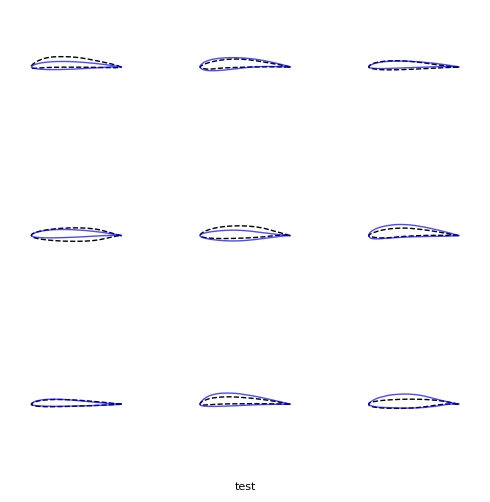

In [5]:
# Randomly sample 9 rows from the DataFrame
validation_airfoils_df = airfoil_dataset.sample(n=9, random_state=SEED)
validation_airfoils = [Airfoil(coordinates=af["coordinates"], name=af["airfoil_name"]) for af in validation_airfoils_df.to_dict(orient="records")]

validation_airfoils_df_2 = airfoil_dataset.sample(n=9, random_state=1)
validation_airfoils_2 = [Airfoil(coordinates=af["coordinates"], name=af["airfoil_name"]) for af in validation_airfoils_df_2.to_dict(orient="records")]

plot_original_and_reconstruction(validation_airfoils, validation_airfoils_2, text_label="test")

In [9]:
# --- Instantiate Model, Optimizer, and Loss ---
vae = CSTVariationalAutoencoder(scaler, npv=NPV, latent_dim=LATENT_DIM)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=CLIPNORM)

# Main Loss (Reconstruction Loss)
# reconstruction_loss = tf.keras.losses.MeanSquaredError()
reconstruction_loss = tf.keras.losses.MeanAbsoluteError()

# --- Training Step (for one batch) ---
@tf.function
def train_step(x_batch, BETA):
    # Open a GradientTape to record operations
    with tf.GradientTape() as tape:
        # Run the forward pass
        _, reco_weights, reco_params = vae(x_batch, training=True)
        reco_weights_flat = tf.reshape(reco_weights, [tf.shape(reco_weights)[0], -1])
        reconstructed_batch = tf.concat([reco_weights_flat, reco_params], axis=1)
        
        # Calculate Main Loss (Reconstruction)
        reco_loss = reconstruction_loss(x_batch, reconstructed_batch)

        # Get KL Loss (added by self.add_loss() inside the model)
        kl_loss = sum(vae.losses)
        
        # Calculate Total Loss
        total_loss = reco_loss + (BETA * kl_loss)
        
    # Calculate Gradients
    gradients = tape.gradient(total_loss, vae.trainable_variables)
    
    # Apply Gradients to update weights
    optimizer.apply_gradients(zip(gradients, vae.trainable_variables))

    # Return the losses for logging
    return total_loss, reco_loss, kl_loss


wandb: Network error (SSLError), entering retry loop.


Starting training...


Epoch 1/3000:   0%|          | 0/32 [00:00<?, ?it/s]c:\Users\MMSOUTO\Documents\Py\Generative_airfoil_models\.venv\Lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'decoder_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
Epoch 1/3000: 100%|██████████| 32/32 [00:07<00:00,  4.15it/s]

Epoch 1/3000, Time: 7.73s, Total Loss: 0.2882, Reco Loss: 0.2882, KL Loss: 429639.6250
Generating and plotting airfoils...


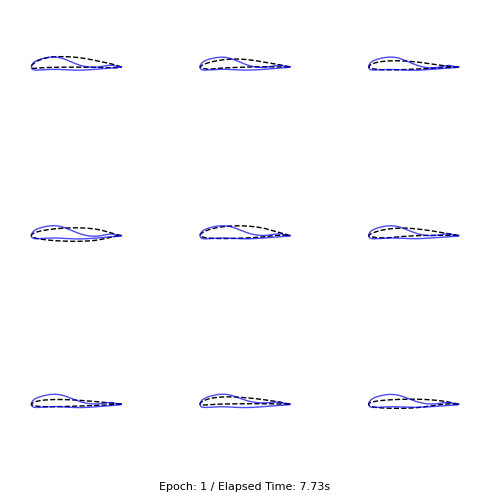

Epoch 2/3000: 100%|██████████| 32/32 [00:03<00:00,  8.09it/s]

Epoch 2/3000, Time: 11.78s, Total Loss: 32.3425, Reco Loss: 0.2135, KL Loss: 3212896.7500
Generating and plotting airfoils...


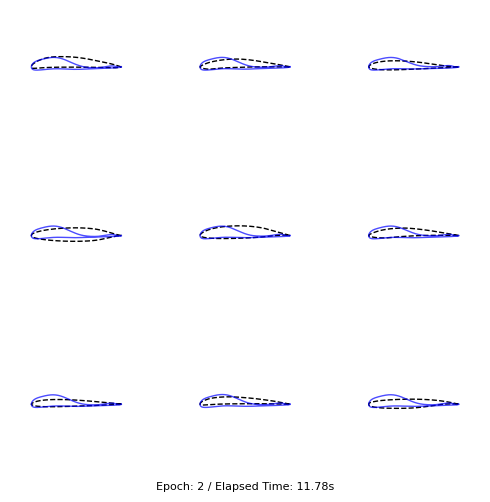

Epoch 3/3000: 100%|██████████| 32/32 [00:04<00:00,  6.69it/s]

Epoch 3/3000, Time: 16.69s, Total Loss: 0.2404, Reco Loss: 0.1841, KL Loss: 2810.8142
Generating and plotting airfoils...


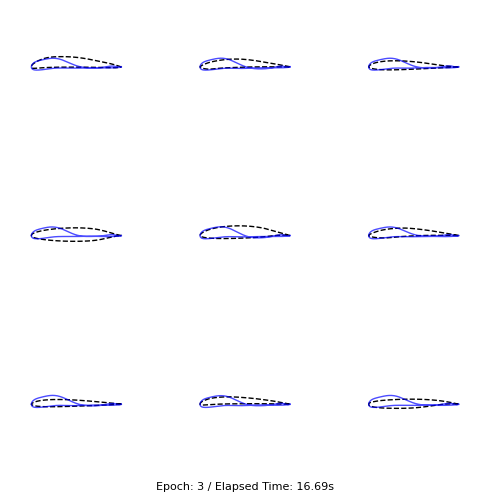

Epoch 4/3000: 100%|██████████| 32/32 [00:05<00:00,  6.39it/s]

Epoch 4/3000, Time: 21.78s, Total Loss: 0.1814, Reco Loss: 0.1767, KL Loss: 158.1796
Generating and plotting airfoils...


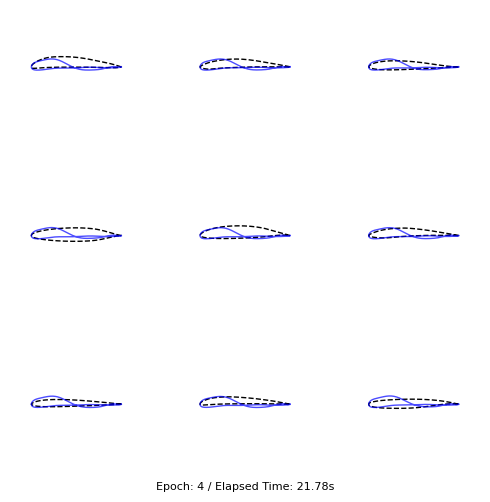

Epoch 5/3000: 100%|██████████| 32/32 [00:09<00:00,  3.33it/s]

Epoch 5/3000, Time: 31.48s, Total Loss: 0.1572, Reco Loss: 0.1533, KL Loss: 97.9342
Generating and plotting airfoils...


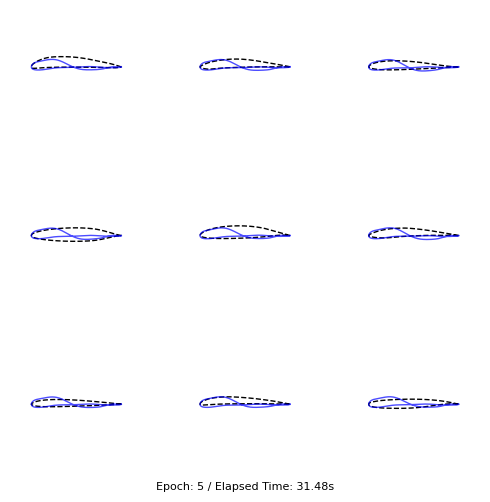

--- Saving model checkpoint for epoch 5 ---


Epoch 6/3000: 100%|██████████| 32/32 [00:05<00:00,  6.03it/s]

Epoch 6/3000, Time: 37.01s, Total Loss: 0.1517, Reco Loss: 0.1439, KL Loss: 155.2789
Generating and plotting airfoils...


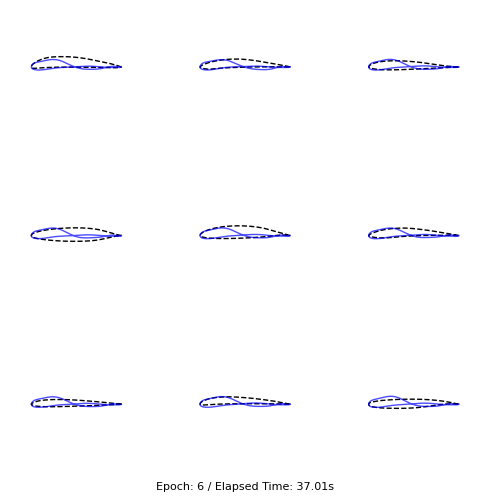

Epoch 7/3000: 100%|██████████| 32/32 [00:04<00:00,  7.87it/s]

Epoch 7/3000, Time: 41.17s, Total Loss: 0.1375, Reco Loss: 0.1329, KL Loss: 76.7081
Generating and plotting airfoils...


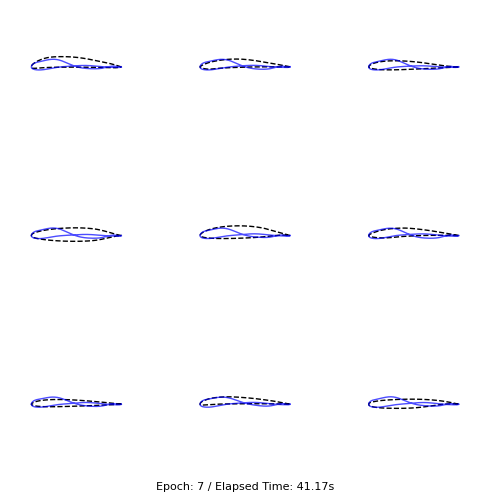

Epoch 8/3000: 100%|██████████| 32/32 [00:05<00:00,  6.32it/s]

Epoch 8/3000, Time: 46.35s, Total Loss: 0.1220, Reco Loss: 0.1190, KL Loss: 42.9178
Generating and plotting airfoils...


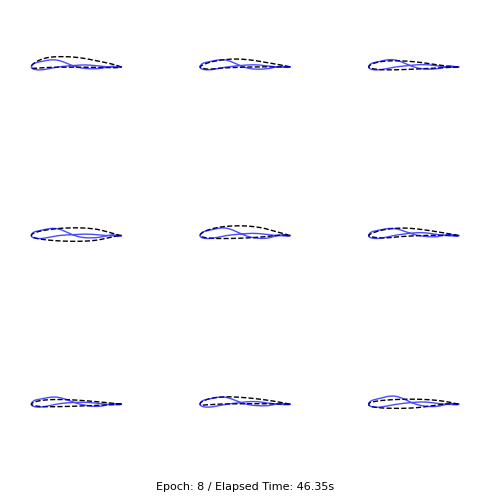

Epoch 9/3000: 100%|██████████| 32/32 [00:04<00:00,  7.16it/s]

Epoch 9/3000, Time: 50.91s, Total Loss: 0.1173, Reco Loss: 0.1162, KL Loss: 14.3448
Generating and plotting airfoils...


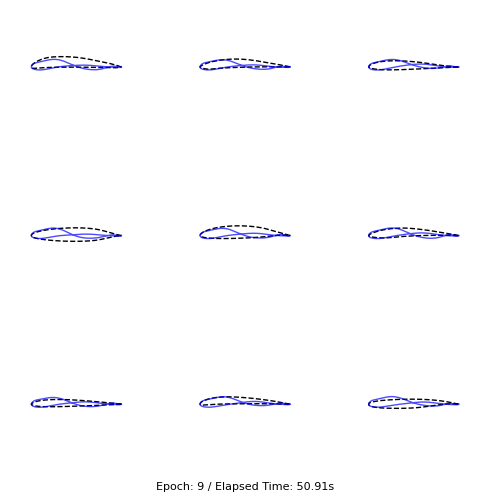

Epoch 10/3000: 100%|██████████| 32/32 [00:03<00:00,  8.78it/s]

Epoch 10/3000, Time: 54.65s, Total Loss: 0.1106, Reco Loss: 0.1087, KL Loss: 20.9944
Generating and plotting airfoils...


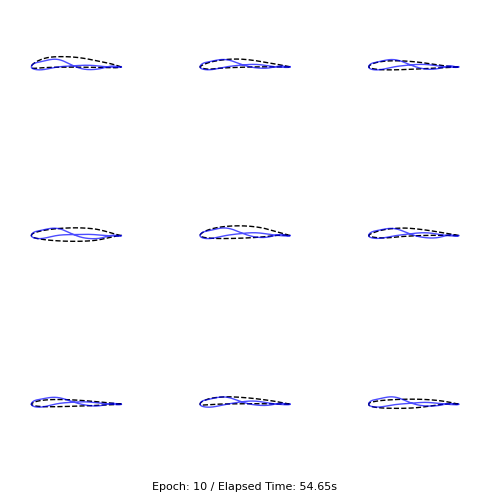

--- Saving model checkpoint for epoch 10 ---


Epoch 11/3000: 100%|██████████| 32/32 [00:04<00:00,  7.19it/s]

Epoch 11/3000, Time: 59.28s, Total Loss: 0.1058, Reco Loss: 0.1034, KL Loss: 23.1545
Generating and plotting airfoils...


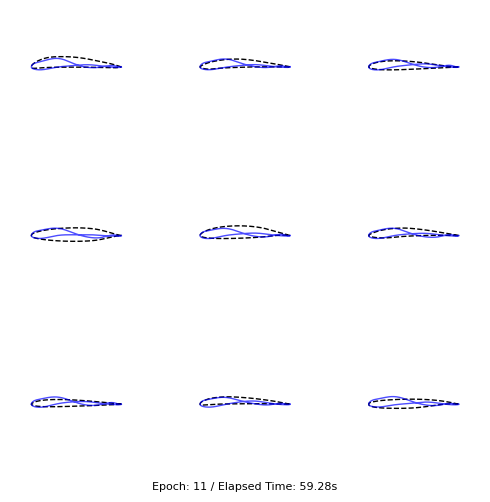

Epoch 12/3000: 100%|██████████| 32/32 [00:04<00:00,  7.77it/s]

Epoch 12/3000, Time: 63.48s, Total Loss: 0.0993, Reco Loss: 0.0982, KL Loss: 9.2891
Generating and plotting airfoils...


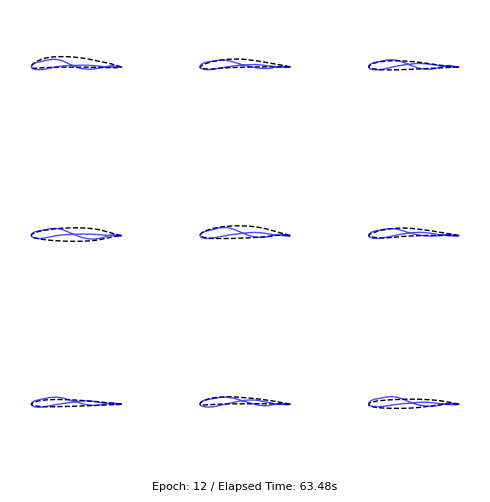

Epoch 13/3000: 100%|██████████| 32/32 [00:04<00:00,  7.63it/s]

Epoch 13/3000, Time: 67.79s, Total Loss: 0.0907, Reco Loss: 0.0896, KL Loss: 8.8983
Generating and plotting airfoils...


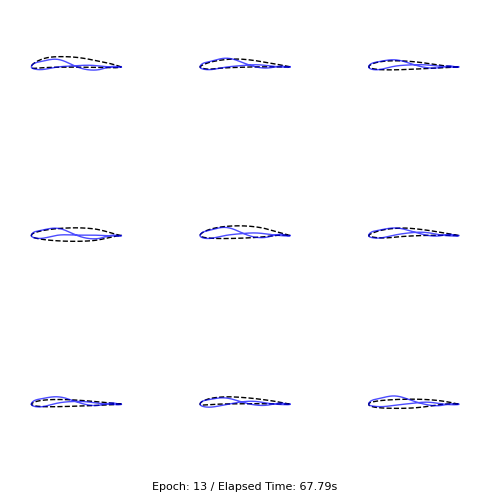

Epoch 14/3000: 100%|██████████| 32/32 [00:04<00:00,  7.37it/s]

Epoch 14/3000, Time: 72.23s, Total Loss: 0.0886, Reco Loss: 0.0867, KL Loss: 14.2929
Generating and plotting airfoils...


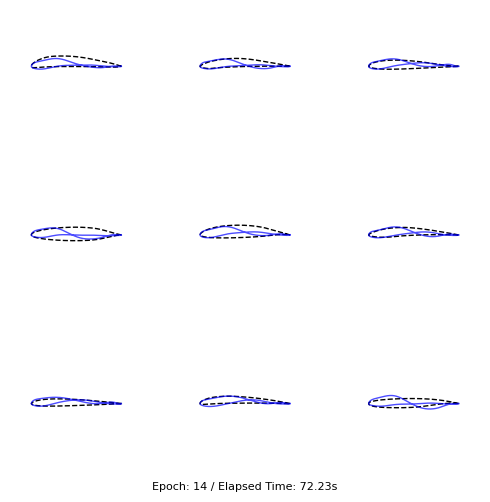

Epoch 15/3000: 100%|██████████| 32/32 [00:03<00:00,  8.36it/s]

Epoch 15/3000, Time: 76.14s, Total Loss: 0.0842, Reco Loss: 0.0828, KL Loss: 10.5281
Generating and plotting airfoils...


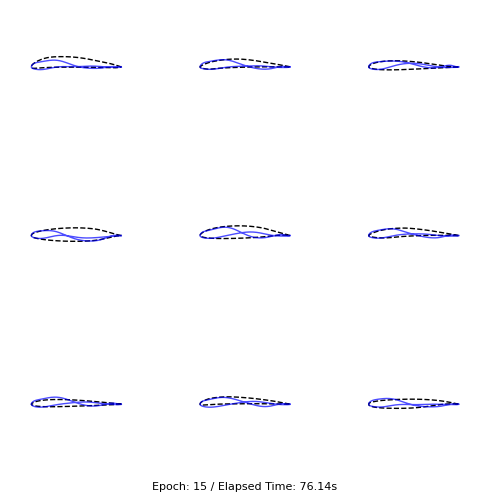

--- Saving model checkpoint for epoch 15 ---


Epoch 16/3000: 100%|██████████| 32/32 [00:04<00:00,  6.40it/s]

Epoch 16/3000, Time: 81.33s, Total Loss: 0.0812, Reco Loss: 0.0803, KL Loss: 5.8499
Generating and plotting airfoils...


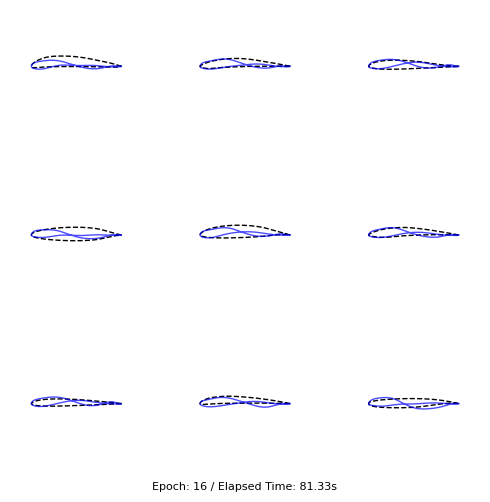

Epoch 17/3000: 100%|██████████| 32/32 [00:04<00:00,  7.14it/s]

Epoch 17/3000, Time: 85.89s, Total Loss: 0.0791, Reco Loss: 0.0782, KL Loss: 5.5636
Generating and plotting airfoils...


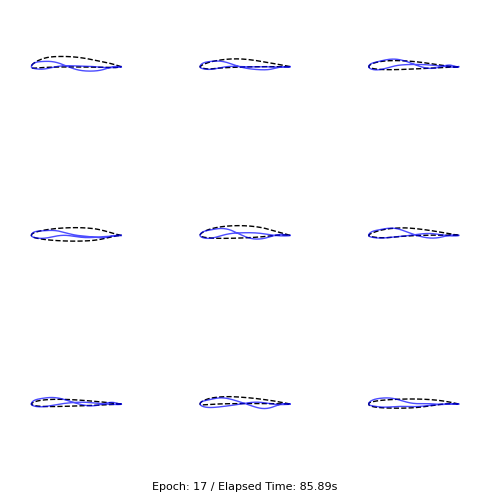

Epoch 18/3000: 100%|██████████| 32/32 [00:03<00:00,  8.54it/s]

Epoch 18/3000, Time: 89.73s, Total Loss: 0.0782, Reco Loss: 0.0775, KL Loss: 4.0049
Generating and plotting airfoils...


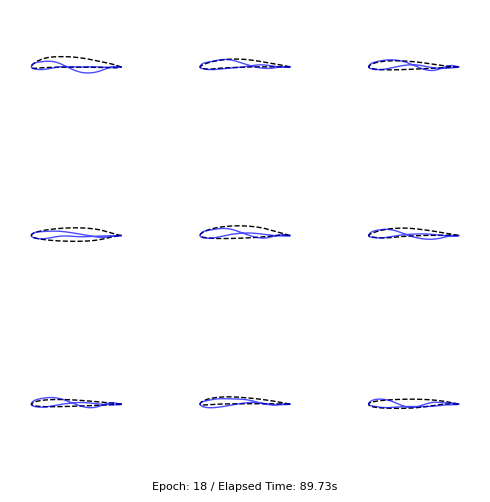

Epoch 19/3000: 100%|██████████| 32/32 [00:04<00:00,  7.20it/s]

Epoch 19/3000, Time: 94.26s, Total Loss: 0.0727, Reco Loss: 0.0718, KL Loss: 5.0656
Generating and plotting airfoils...


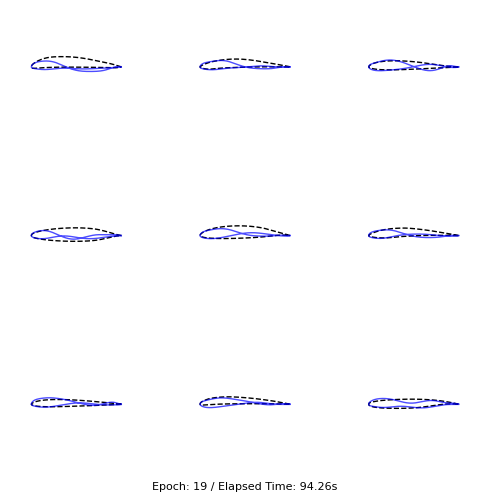

Epoch 20/3000: 100%|██████████| 32/32 [00:04<00:00,  7.61it/s]


Epoch 20/3000, Time: 98.54s, Total Loss: 0.0714, Reco Loss: 0.0707, KL Loss: 3.7565
Generating and plotting airfoils...


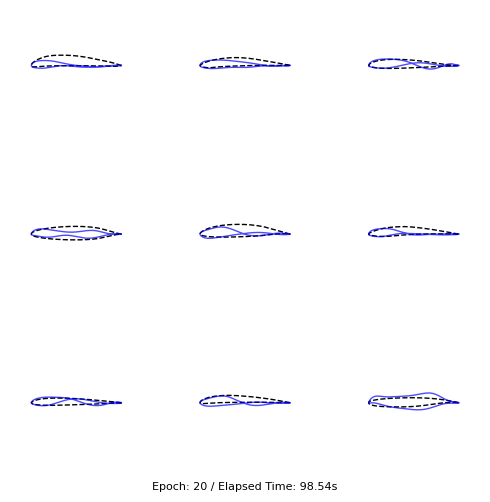

--- Saving model checkpoint for epoch 20 ---


Epoch 21/3000: 100%|██████████| 32/32 [00:04<00:00,  6.92it/s]

Epoch 21/3000, Time: 110.39s, Total Loss: 0.0703, Reco Loss: 0.0694, KL Loss: 4.7687
Generating and plotting airfoils...


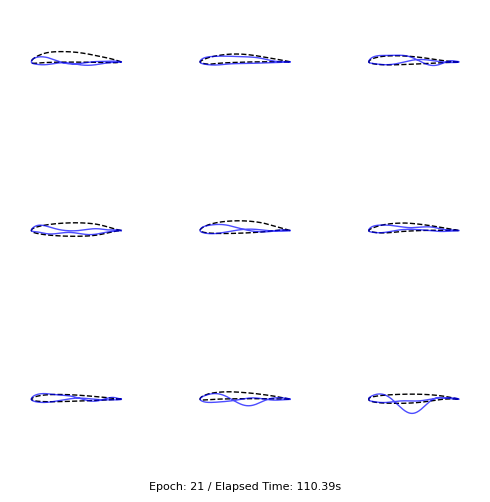

Epoch 22/3000: 100%|██████████| 32/32 [00:03<00:00,  8.35it/s]

Epoch 22/3000, Time: 114.31s, Total Loss: 0.0687, Reco Loss: 0.0679, KL Loss: 3.5901
Generating and plotting airfoils...


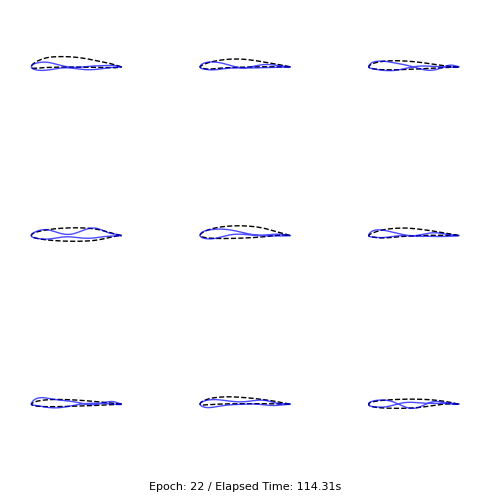

Epoch 23/3000: 100%|██████████| 32/32 [00:04<00:00,  7.31it/s]

Epoch 23/3000, Time: 118.80s, Total Loss: 0.0676, Reco Loss: 0.0668, KL Loss: 3.5478
Generating and plotting airfoils...


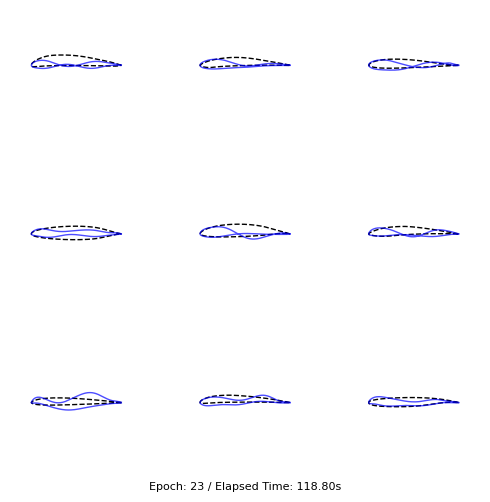

Epoch 24/3000: 100%|██████████| 32/32 [00:04<00:00,  7.26it/s]

Epoch 24/3000, Time: 123.29s, Total Loss: 0.0643, Reco Loss: 0.0636, KL Loss: 2.8076
Generating and plotting airfoils...


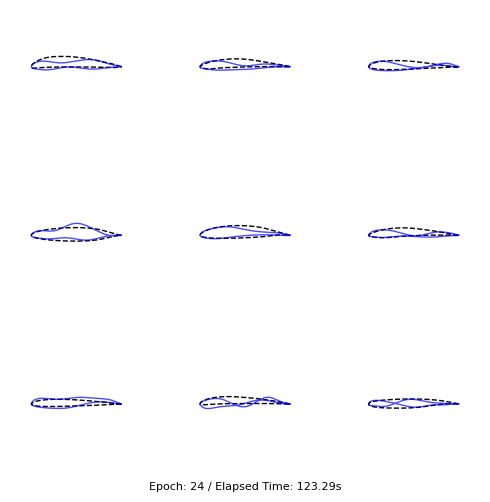

Epoch 25/3000: 100%|██████████| 32/32 [00:04<00:00,  7.99it/s]

Epoch 25/3000, Time: 127.38s, Total Loss: 0.0626, Reco Loss: 0.0619, KL Loss: 3.0499
Generating and plotting airfoils...


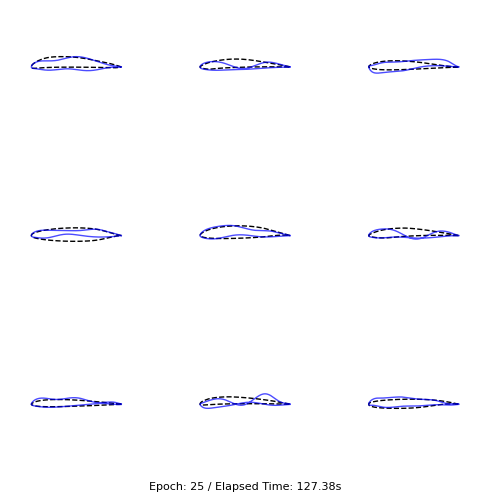

--- Saving model checkpoint for epoch 25 ---


Epoch 26/3000: 100%|██████████| 32/32 [00:04<00:00,  6.80it/s]

Epoch 26/3000, Time: 132.34s, Total Loss: 0.0610, Reco Loss: 0.0601, KL Loss: 3.5261
Generating and plotting airfoils...


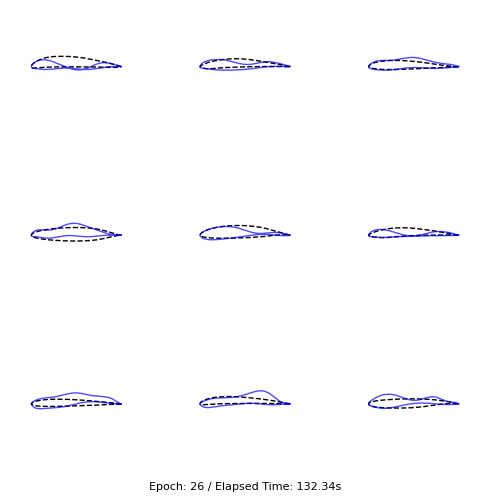

Epoch 27/3000: 100%|██████████| 32/32 [00:05<00:00,  6.36it/s]

Epoch 27/3000, Time: 137.47s, Total Loss: 0.0604, Reco Loss: 0.0596, KL Loss: 2.8667
Generating and plotting airfoils...


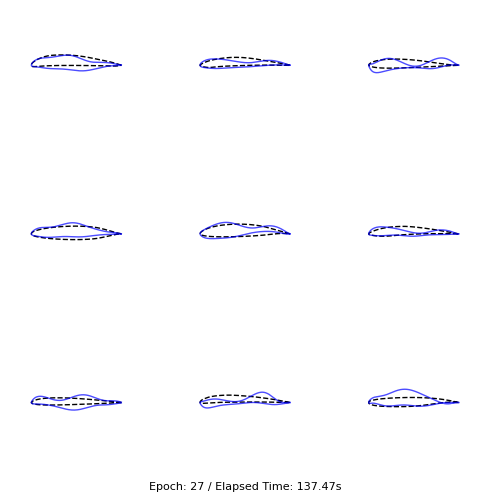

Epoch 28/3000: 100%|██████████| 32/32 [00:03<00:00,  8.11it/s]

Epoch 28/3000, Time: 141.49s, Total Loss: 0.0588, Reco Loss: 0.0582, KL Loss: 2.3017
Generating and plotting airfoils...


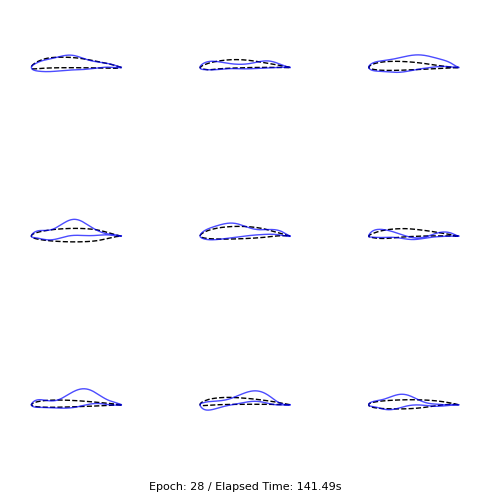

Epoch 29/3000: 100%|██████████| 32/32 [00:04<00:00,  6.87it/s]

Epoch 29/3000, Time: 146.24s, Total Loss: 0.0582, Reco Loss: 0.0576, KL Loss: 2.3398
Generating and plotting airfoils...


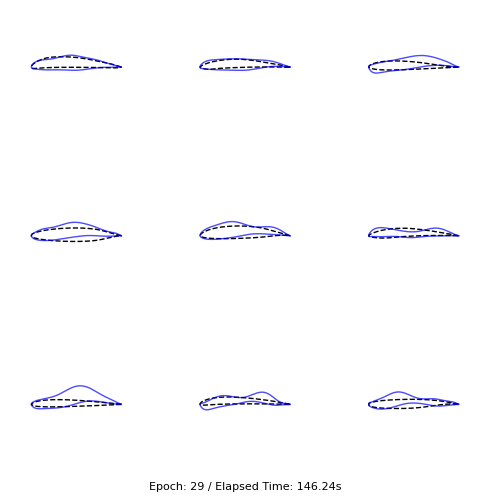

Epoch 30/3000: 100%|██████████| 32/32 [00:04<00:00,  7.14it/s]

Epoch 30/3000, Time: 150.81s, Total Loss: 0.0567, Reco Loss: 0.0561, KL Loss: 2.1994
Generating and plotting airfoils...


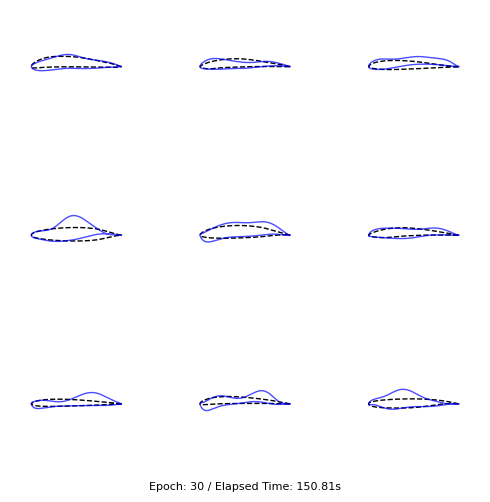

--- Saving model checkpoint for epoch 30 ---


Epoch 31/3000: 100%|██████████| 32/32 [00:03<00:00,  8.33it/s]

Epoch 31/3000, Time: 154.85s, Total Loss: 0.0547, Reco Loss: 0.0541, KL Loss: 2.2303
Generating and plotting airfoils...


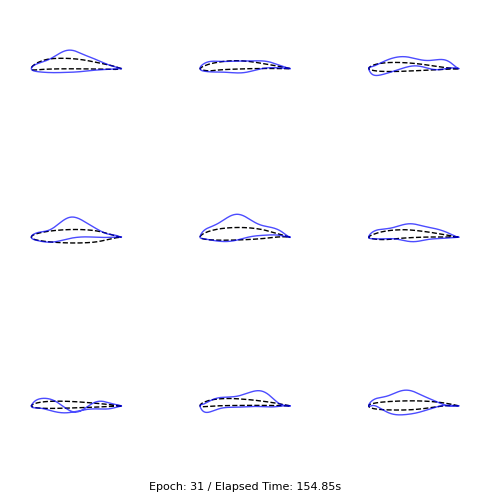

Epoch 32/3000: 100%|██████████| 32/32 [00:04<00:00,  6.72it/s]

Epoch 32/3000, Time: 159.69s, Total Loss: 0.0538, Reco Loss: 0.0531, KL Loss: 2.1744
Generating and plotting airfoils...


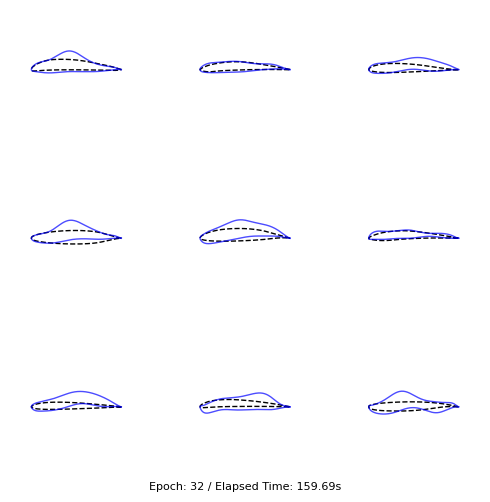

Epoch 33/3000: 100%|██████████| 32/32 [00:04<00:00,  7.15it/s]

Epoch 33/3000, Time: 164.26s, Total Loss: 0.0529, Reco Loss: 0.0523, KL Loss: 2.1209
Generating and plotting airfoils...


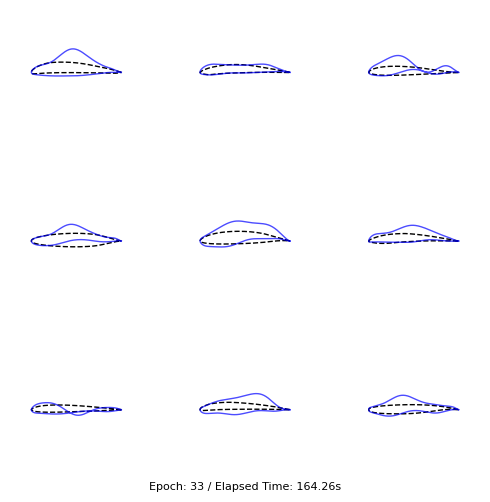

Epoch 34/3000: 100%|██████████| 32/32 [00:04<00:00,  7.37it/s]

Epoch 34/3000, Time: 168.71s, Total Loss: 0.0521, Reco Loss: 0.0514, KL Loss: 2.2790
Generating and plotting airfoils...


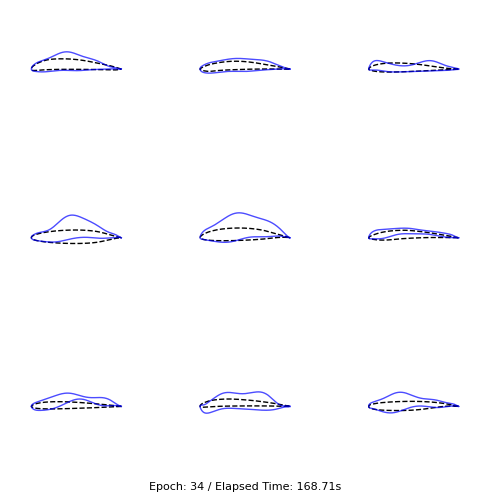

Epoch 35/3000: 100%|██████████| 32/32 [00:04<00:00,  7.15it/s]

Epoch 35/3000, Time: 173.27s, Total Loss: 0.0514, Reco Loss: 0.0507, KL Loss: 2.1088
Generating and plotting airfoils...


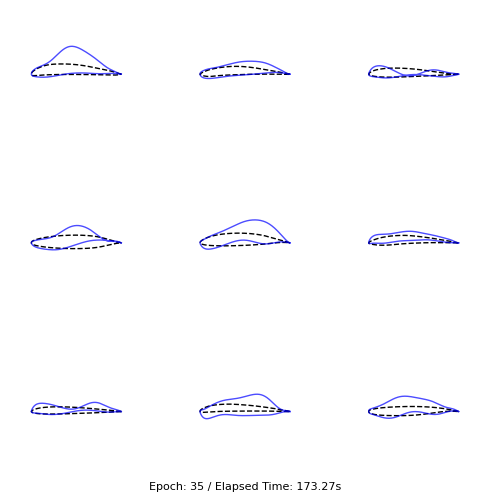

--- Saving model checkpoint for epoch 35 ---


Epoch 36/3000: 100%|██████████| 32/32 [00:04<00:00,  7.98it/s]

Epoch 36/3000, Time: 177.46s, Total Loss: 0.0505, Reco Loss: 0.0497, KL Loss: 2.0747
Generating and plotting airfoils...


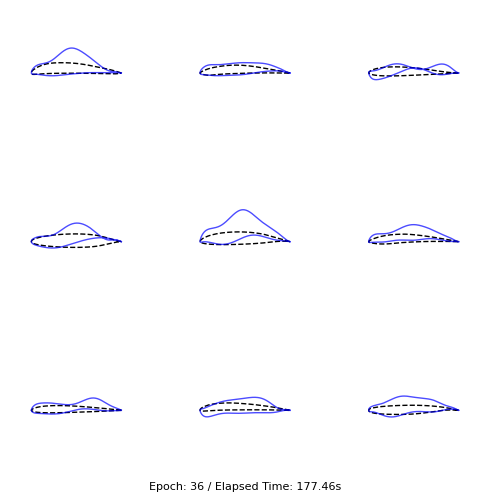

Epoch 37/3000: 100%|██████████| 32/32 [00:04<00:00,  7.18it/s]

Epoch 37/3000, Time: 182.05s, Total Loss: 0.0489, Reco Loss: 0.0482, KL Loss: 2.0580
Generating and plotting airfoils...


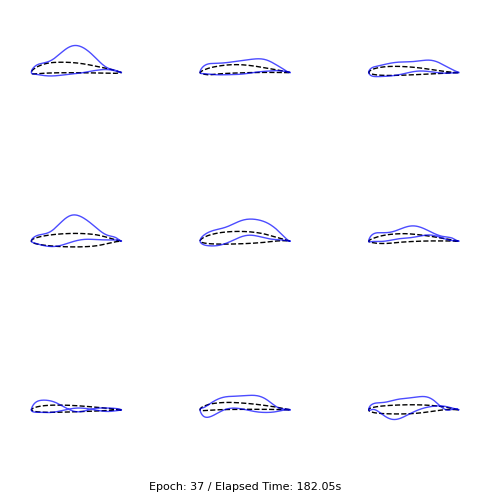

Epoch 38/3000: 100%|██████████| 32/32 [00:04<00:00,  6.79it/s]

Epoch 38/3000, Time: 186.84s, Total Loss: 0.0492, Reco Loss: 0.0485, KL Loss: 2.0635
Generating and plotting airfoils...


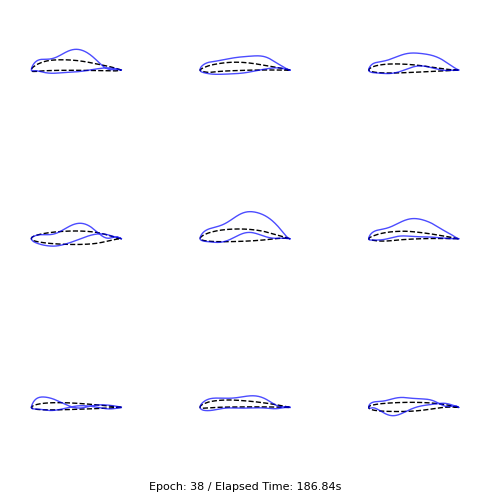

Epoch 39/3000: 100%|██████████| 32/32 [00:04<00:00,  7.72it/s]

Epoch 39/3000, Time: 191.11s, Total Loss: 0.0476, Reco Loss: 0.0468, KL Loss: 2.0016
Generating and plotting airfoils...


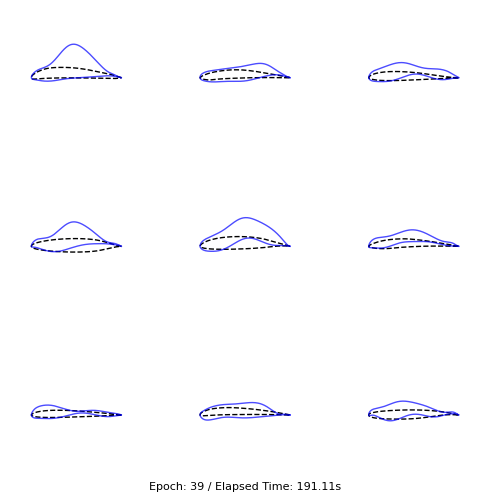

Epoch 40/3000: 100%|██████████| 32/32 [00:04<00:00,  6.92it/s]

Epoch 40/3000, Time: 195.86s, Total Loss: 0.0460, Reco Loss: 0.0452, KL Loss: 2.0270
Generating and plotting airfoils...


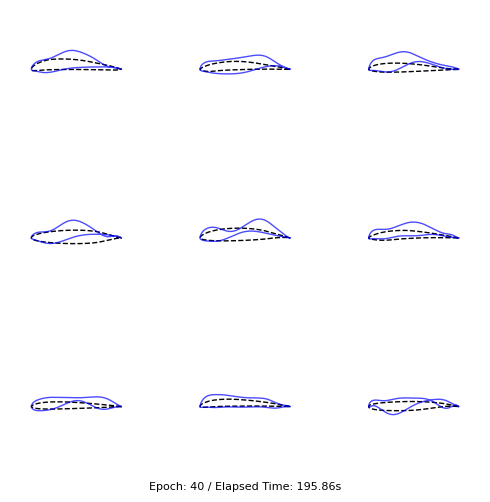

--- Saving model checkpoint for epoch 40 ---


Epoch 41/3000: 100%|██████████| 32/32 [00:04<00:00,  7.24it/s]

Epoch 41/3000, Time: 200.45s, Total Loss: 0.0455, Reco Loss: 0.0447, KL Loss: 2.0035
Generating and plotting airfoils...


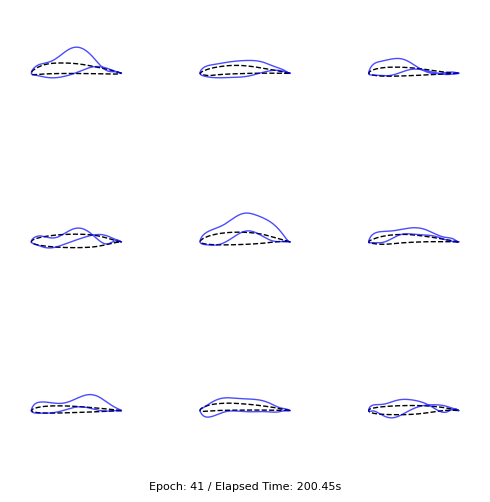

Epoch 42/3000: 100%|██████████| 32/32 [00:04<00:00,  6.99it/s]

Epoch 42/3000, Time: 205.12s, Total Loss: 0.0461, Reco Loss: 0.0453, KL Loss: 1.9690
Generating and plotting airfoils...


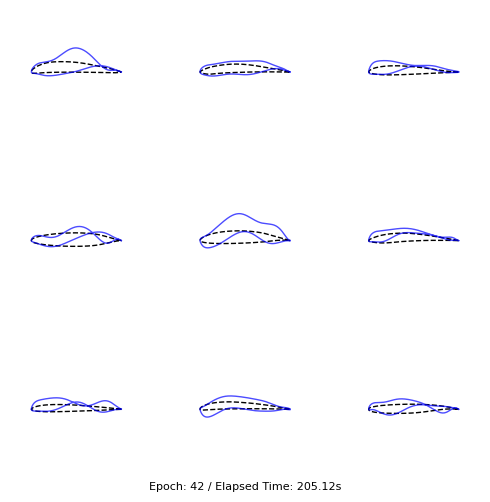

Epoch 43/3000: 100%|██████████| 32/32 [00:07<00:00,  4.57it/s]

Epoch 43/3000, Time: 212.28s, Total Loss: 0.0449, Reco Loss: 0.0441, KL Loss: 1.9929
Generating and plotting airfoils...


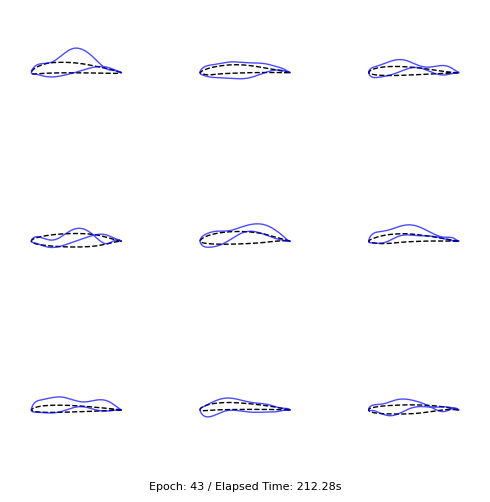

Epoch 44/3000: 100%|██████████| 32/32 [00:07<00:00,  4.54it/s]

Epoch 44/3000, Time: 219.56s, Total Loss: 0.0450, Reco Loss: 0.0441, KL Loss: 1.9671
Generating and plotting airfoils...


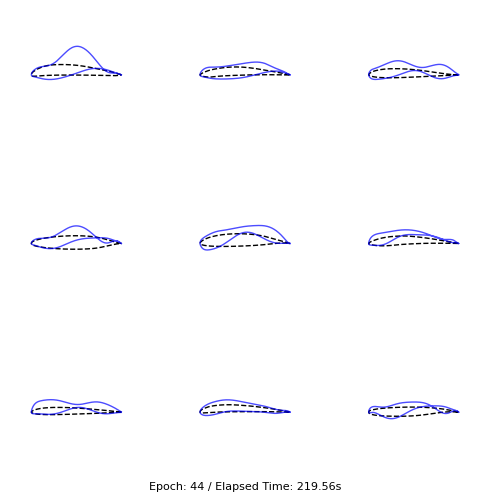

Epoch 45/3000: 100%|██████████| 32/32 [00:05<00:00,  5.89it/s]

Epoch 45/3000, Time: 225.11s, Total Loss: 0.0436, Reco Loss: 0.0428, KL Loss: 1.9644
Generating and plotting airfoils...


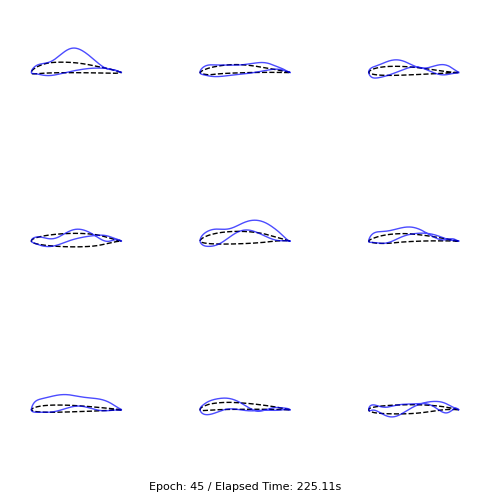

--- Saving model checkpoint for epoch 45 ---


Epoch 46/3000: 100%|██████████| 32/32 [00:05<00:00,  6.02it/s]

Epoch 46/3000, Time: 230.86s, Total Loss: 0.0424, Reco Loss: 0.0415, KL Loss: 2.0091
Generating and plotting airfoils...


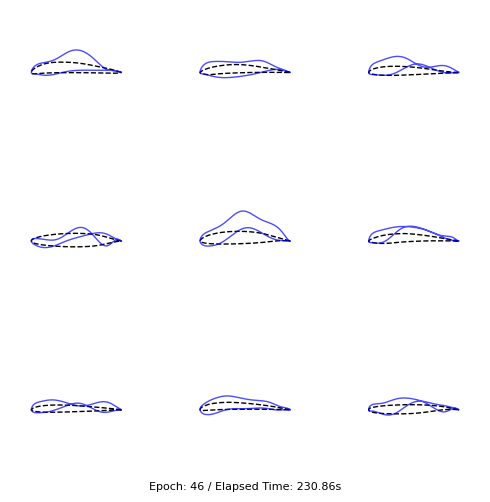

Epoch 47/3000: 100%|██████████| 32/32 [00:04<00:00,  6.98it/s]

Epoch 47/3000, Time: 235.56s, Total Loss: 0.0428, Reco Loss: 0.0419, KL Loss: 2.0250
Generating and plotting airfoils...


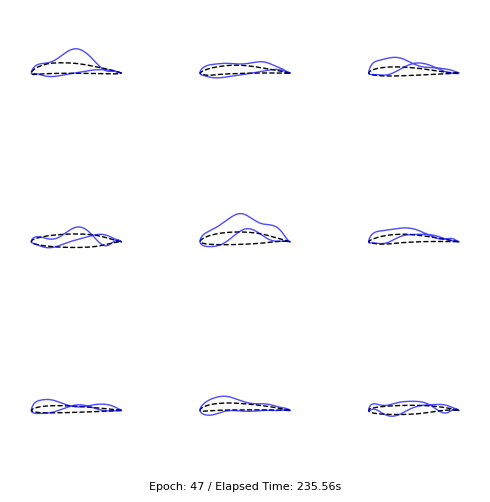

Epoch 48/3000: 100%|██████████| 32/32 [00:04<00:00,  6.72it/s]

Epoch 48/3000, Time: 240.41s, Total Loss: 0.0416, Reco Loss: 0.0407, KL Loss: 2.0322
Generating and plotting airfoils...


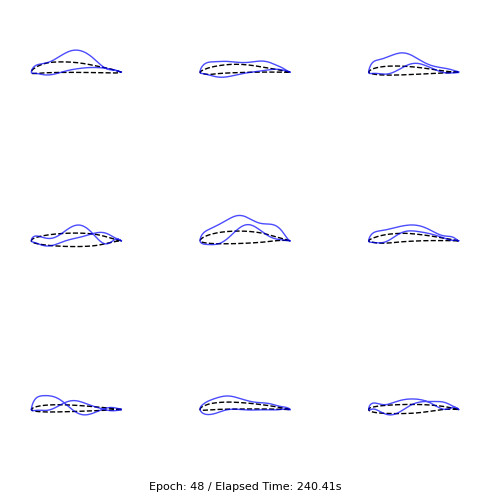

Epoch 49/3000: 100%|██████████| 32/32 [00:04<00:00,  6.59it/s]

Epoch 49/3000, Time: 245.35s, Total Loss: 0.0418, Reco Loss: 0.0409, KL Loss: 1.9891
Generating and plotting airfoils...


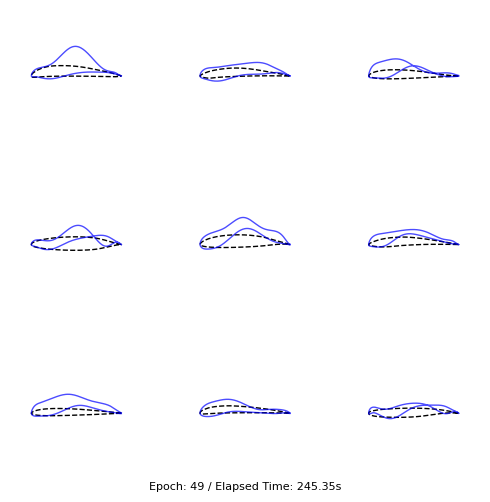

Epoch 50/3000: 100%|██████████| 32/32 [00:04<00:00,  7.25it/s]

Epoch 50/3000, Time: 249.87s, Total Loss: 0.0422, Reco Loss: 0.0412, KL Loss: 2.0160
Generating and plotting airfoils...


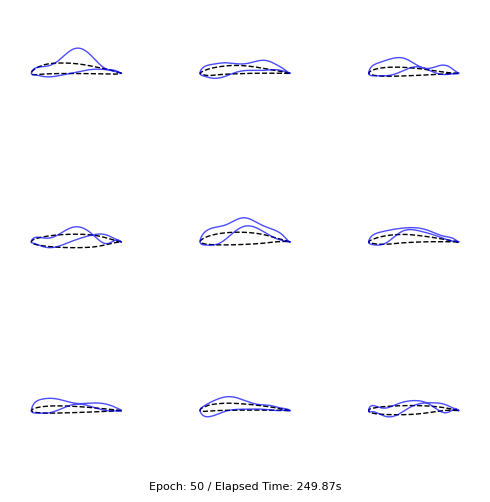

--- Saving model checkpoint for epoch 50 ---


Epoch 51/3000: 100%|██████████| 32/32 [00:05<00:00,  6.38it/s]

Epoch 51/3000, Time: 255.11s, Total Loss: 0.0406, Reco Loss: 0.0396, KL Loss: 2.0235
Generating and plotting airfoils...


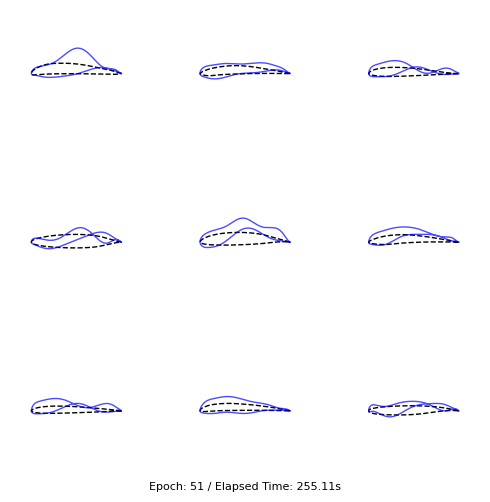

Epoch 52/3000: 100%|██████████| 32/32 [00:05<00:00,  6.36it/s]

Epoch 52/3000, Time: 260.24s, Total Loss: 0.0401, Reco Loss: 0.0391, KL Loss: 2.0334
Generating and plotting airfoils...


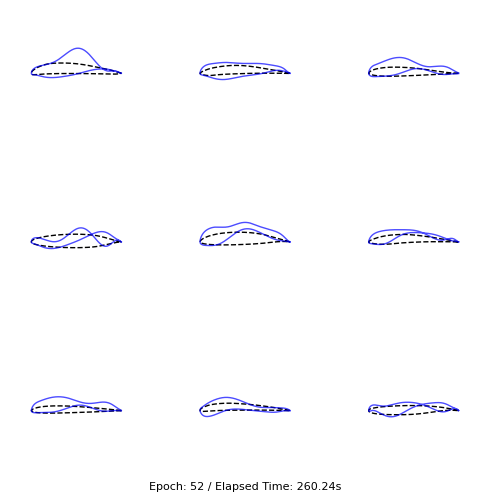

Epoch 53/3000: 100%|██████████| 32/32 [00:04<00:00,  7.31it/s]

Epoch 53/3000, Time: 264.72s, Total Loss: 0.0399, Reco Loss: 0.0388, KL Loss: 2.0511
Generating and plotting airfoils...


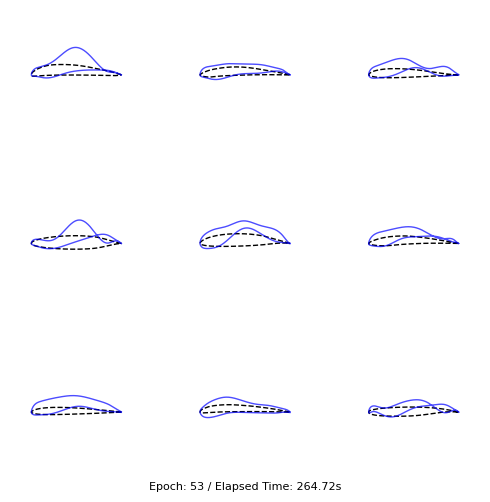

Epoch 54/3000: 100%|██████████| 32/32 [00:05<00:00,  6.35it/s]

Epoch 54/3000, Time: 269.89s, Total Loss: 0.0392, Reco Loss: 0.0381, KL Loss: 2.0785
Generating and plotting airfoils...


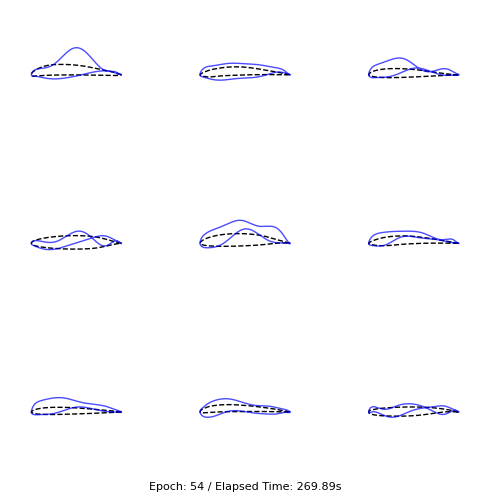

Epoch 55/3000: 100%|██████████| 32/32 [00:05<00:00,  5.60it/s]

Epoch 55/3000, Time: 275.71s, Total Loss: 0.0393, Reco Loss: 0.0382, KL Loss: 2.0713
Generating and plotting airfoils...


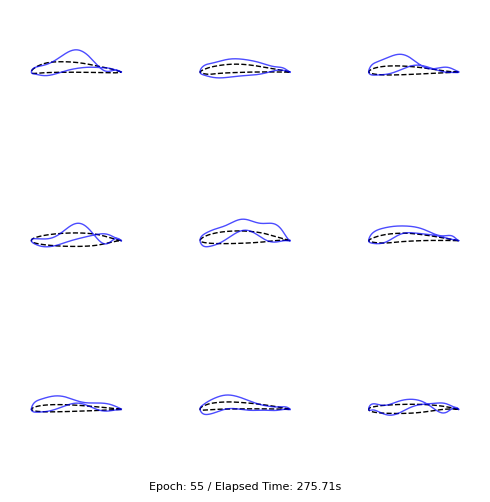

--- Saving model checkpoint for epoch 55 ---


Epoch 56/3000: 100%|██████████| 32/32 [00:04<00:00,  6.58it/s]

Epoch 56/3000, Time: 280.84s, Total Loss: 0.0384, Reco Loss: 0.0372, KL Loss: 2.0543
Generating and plotting airfoils...


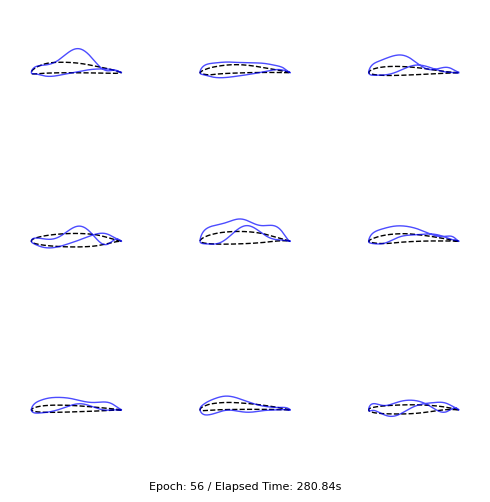

Epoch 57/3000: 100%|██████████| 32/32 [00:04<00:00,  6.51it/s]

Epoch 57/3000, Time: 285.90s, Total Loss: 0.0378, Reco Loss: 0.0367, KL Loss: 2.0668
Generating and plotting airfoils...


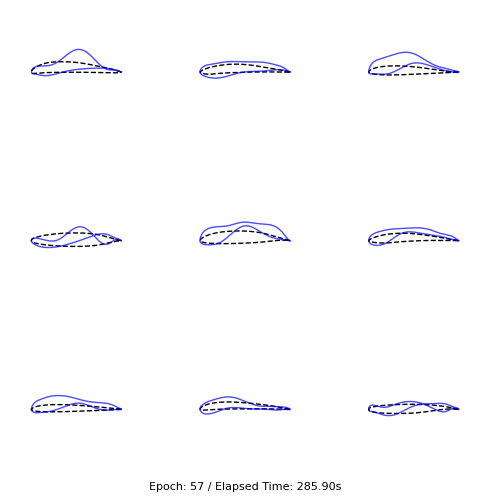

Epoch 58/3000: 100%|██████████| 32/32 [00:06<00:00,  5.17it/s]

Epoch 58/3000, Time: 292.19s, Total Loss: 0.0374, Reco Loss: 0.0362, KL Loss: 2.0784
Generating and plotting airfoils...


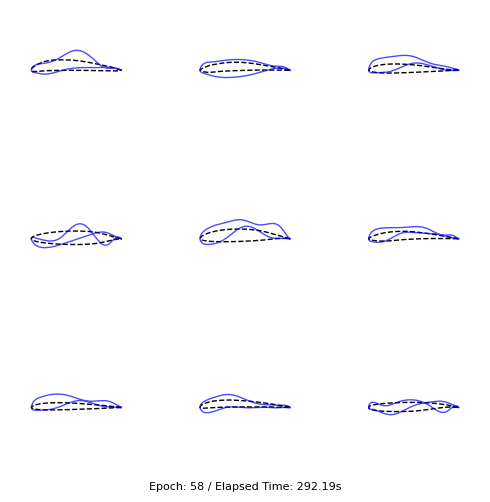

Epoch 59/3000: 100%|██████████| 32/32 [00:06<00:00,  5.29it/s]

Epoch 59/3000, Time: 298.36s, Total Loss: 0.0369, Reco Loss: 0.0357, KL Loss: 2.0680
Generating and plotting airfoils...


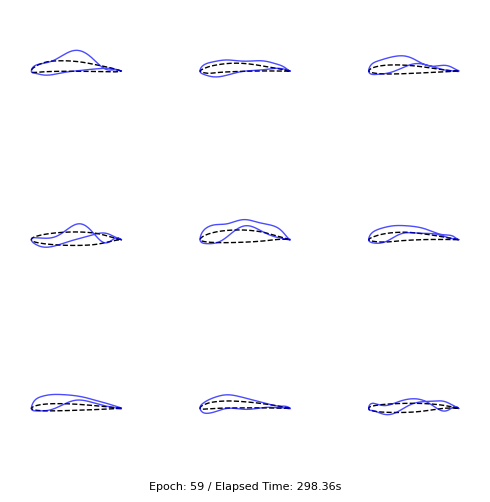

Epoch 60/3000: 100%|██████████| 32/32 [00:05<00:00,  6.05it/s]

Epoch 60/3000, Time: 303.76s, Total Loss: 0.0368, Reco Loss: 0.0355, KL Loss: 2.0736
Generating and plotting airfoils...


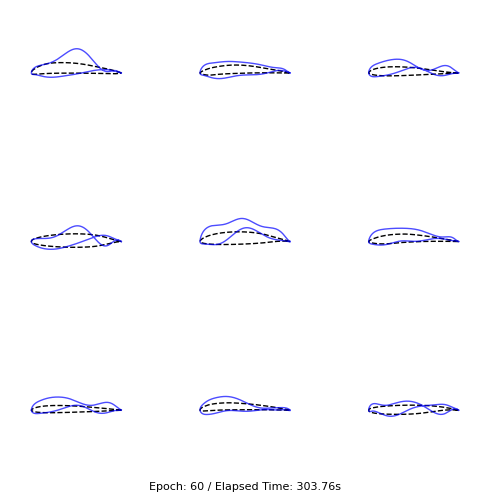

--- Saving model checkpoint for epoch 60 ---


Epoch 61/3000: 100%|██████████| 32/32 [00:05<00:00,  5.72it/s]

Epoch 61/3000, Time: 309.63s, Total Loss: 0.0363, Reco Loss: 0.0350, KL Loss: 2.0940
Generating and plotting airfoils...


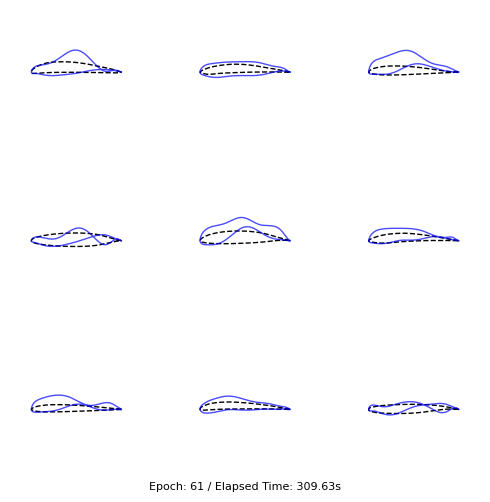

Epoch 62/3000: 100%|██████████| 32/32 [00:05<00:00,  6.03it/s]

Epoch 62/3000, Time: 315.04s, Total Loss: 0.0361, Reco Loss: 0.0348, KL Loss: 2.0998
Generating and plotting airfoils...


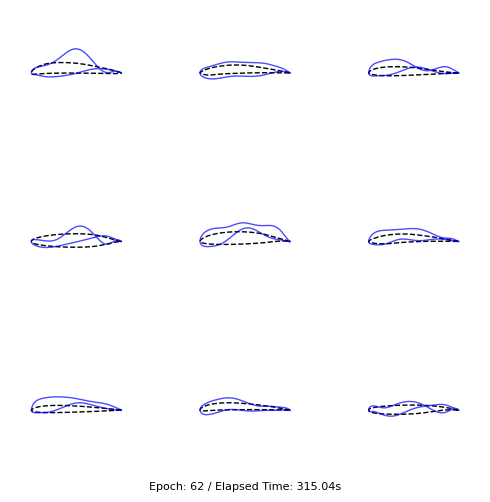

Epoch 63/3000: 100%|██████████| 32/32 [00:04<00:00,  6.43it/s]

Epoch 63/3000, Time: 320.11s, Total Loss: 0.0363, Reco Loss: 0.0350, KL Loss: 2.1001
Generating and plotting airfoils...


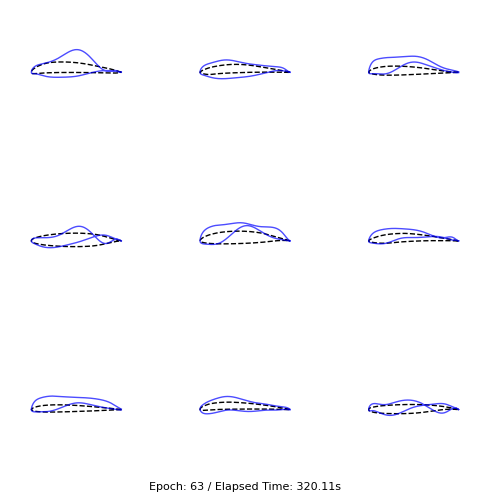

Epoch 64/3000: 100%|██████████| 32/32 [00:04<00:00,  7.05it/s]

Epoch 64/3000, Time: 324.79s, Total Loss: 0.0351, Reco Loss: 0.0338, KL Loss: 2.1093
Generating and plotting airfoils...


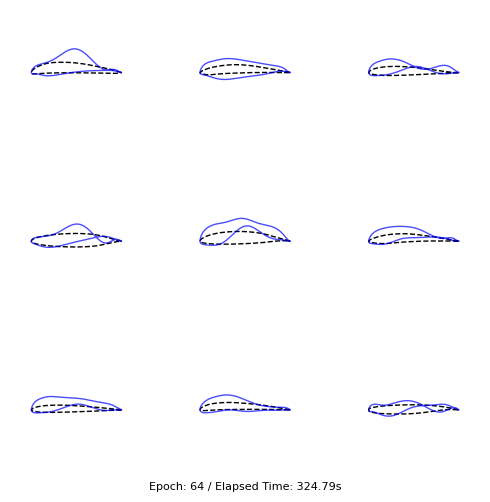

Epoch 65/3000: 100%|██████████| 32/32 [00:05<00:00,  5.92it/s]

Epoch 65/3000, Time: 330.32s, Total Loss: 0.0358, Reco Loss: 0.0344, KL Loss: 2.1209
Generating and plotting airfoils...


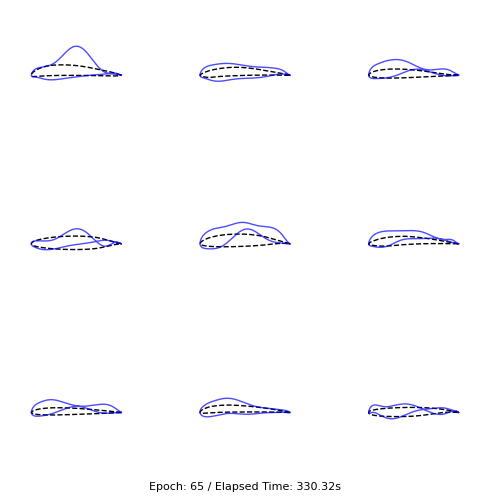

--- Saving model checkpoint for epoch 65 ---


Epoch 66/3000: 100%|██████████| 32/32 [00:05<00:00,  5.92it/s]

Epoch 66/3000, Time: 335.97s, Total Loss: 0.0362, Reco Loss: 0.0348, KL Loss: 2.1101
Generating and plotting airfoils...


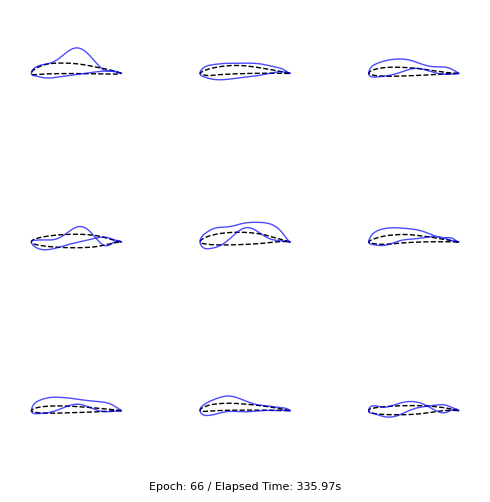

Epoch 67/3000: 100%|██████████| 32/32 [00:04<00:00,  6.46it/s]

Epoch 67/3000, Time: 341.04s, Total Loss: 0.0357, Reco Loss: 0.0344, KL Loss: 2.1087
Generating and plotting airfoils...


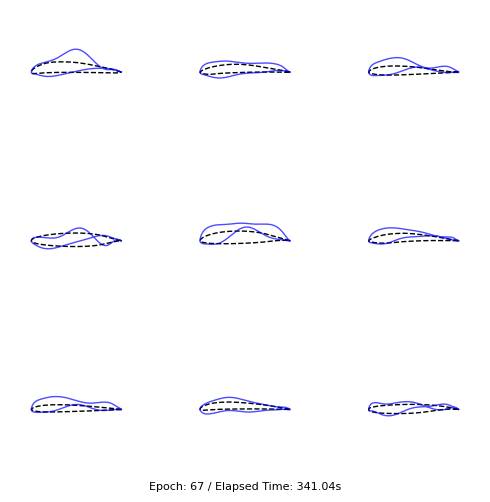

Epoch 68/3000: 100%|██████████| 32/32 [00:04<00:00,  6.61it/s]

Epoch 68/3000, Time: 346.01s, Total Loss: 0.0362, Reco Loss: 0.0348, KL Loss: 2.1070
Generating and plotting airfoils...


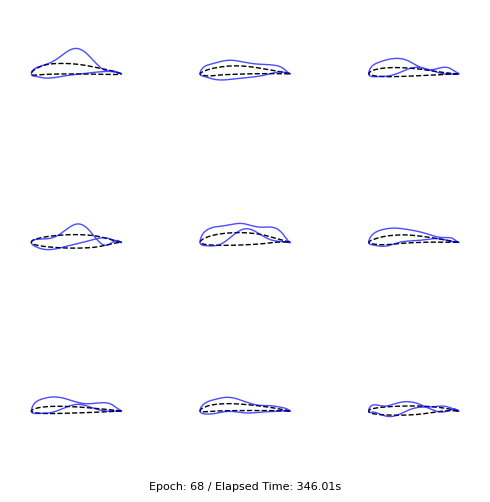

Epoch 69/3000: 100%|██████████| 32/32 [00:05<00:00,  6.22it/s]

Epoch 69/3000, Time: 351.25s, Total Loss: 0.0342, Reco Loss: 0.0328, KL Loss: 2.0939
Generating and plotting airfoils...


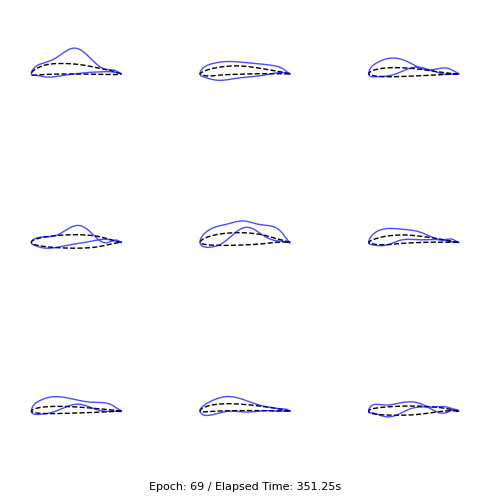

Epoch 70/3000: 100%|██████████| 32/32 [00:05<00:00,  6.20it/s]

Epoch 70/3000, Time: 356.51s, Total Loss: 0.0348, Reco Loss: 0.0334, KL Loss: 2.1089
Generating and plotting airfoils...


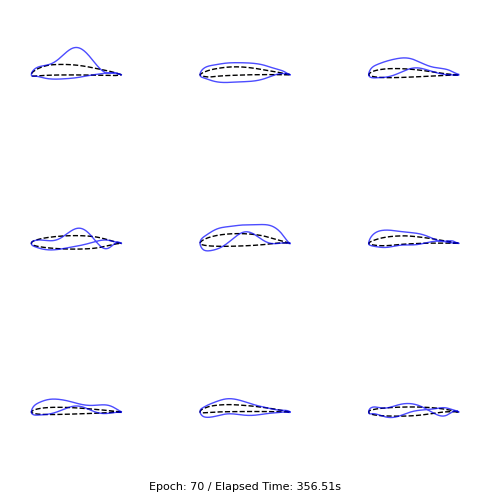

--- Saving model checkpoint for epoch 70 ---


Epoch 71/3000: 100%|██████████| 32/32 [00:04<00:00,  7.39it/s]

Epoch 71/3000, Time: 361.09s, Total Loss: 0.0344, Reco Loss: 0.0329, KL Loss: 2.1114
Generating and plotting airfoils...


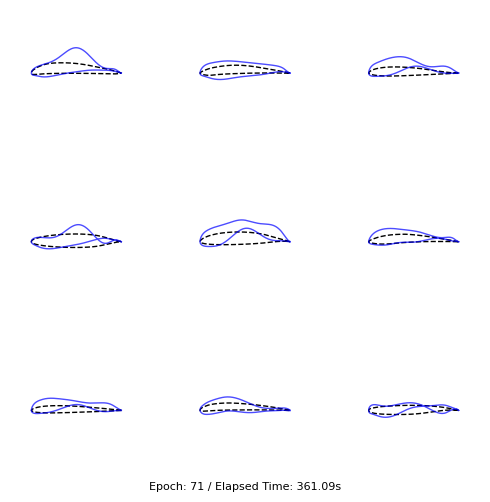

Epoch 72/3000: 100%|██████████| 32/32 [00:05<00:00,  6.12it/s]

Epoch 72/3000, Time: 366.42s, Total Loss: 0.0347, Reco Loss: 0.0332, KL Loss: 2.0973
Generating and plotting airfoils...


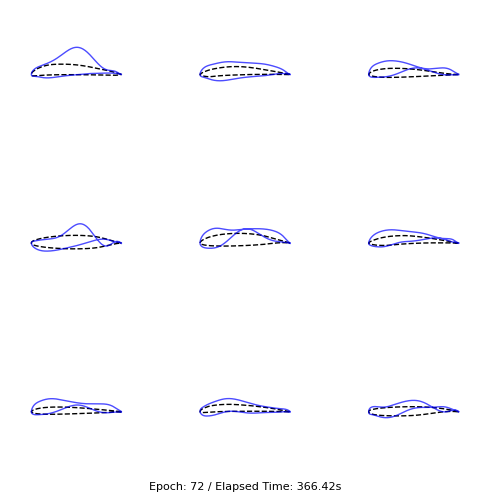

Epoch 73/3000: 100%|██████████| 32/32 [00:05<00:00,  5.50it/s]

Epoch 73/3000, Time: 372.34s, Total Loss: 0.0330, Reco Loss: 0.0315, KL Loss: 2.1128
Generating and plotting airfoils...


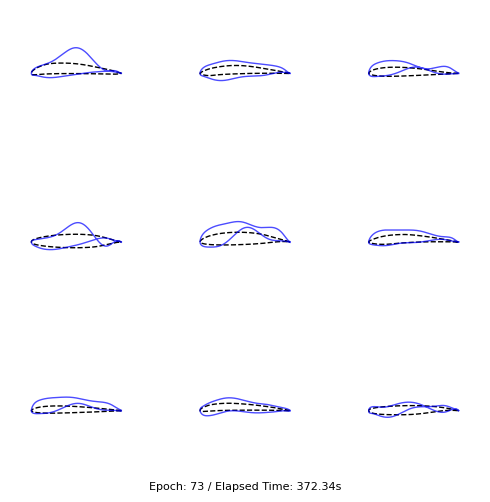

Epoch 74/3000: 100%|██████████| 32/32 [00:06<00:00,  4.80it/s]

Epoch 74/3000, Time: 379.11s, Total Loss: 0.0344, Reco Loss: 0.0329, KL Loss: 2.1224
Generating and plotting airfoils...


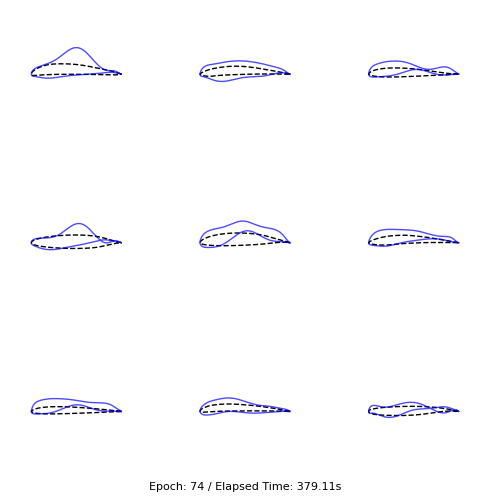

Epoch 75/3000: 100%|██████████| 32/32 [00:05<00:00,  5.62it/s]


Epoch 75/3000, Time: 384.92s, Total Loss: 0.0335, Reco Loss: 0.0320, KL Loss: 2.1094
Generating and plotting airfoils...


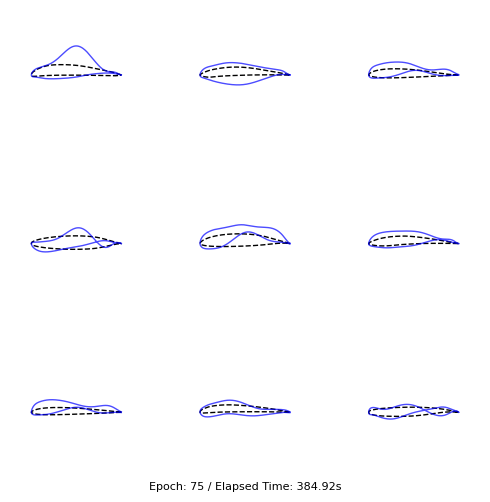

--- Saving model checkpoint for epoch 75 ---


Epoch 76/3000: 100%|██████████| 32/32 [00:04<00:00,  6.56it/s]

Epoch 76/3000, Time: 390.20s, Total Loss: 0.0315, Reco Loss: 0.0299, KL Loss: 2.1208
Generating and plotting airfoils...


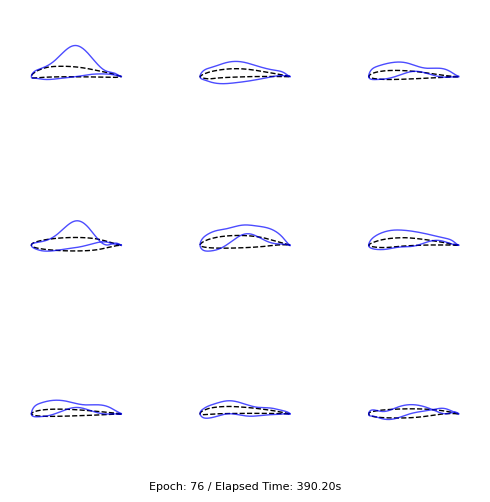

Epoch 77/3000: 100%|██████████| 32/32 [00:05<00:00,  5.93it/s]

Epoch 77/3000, Time: 395.70s, Total Loss: 0.0328, Reco Loss: 0.0312, KL Loss: 2.1385
Generating and plotting airfoils...


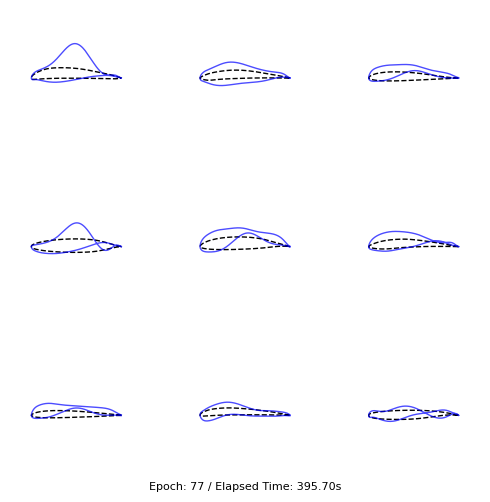

Epoch 78/3000: 100%|██████████| 32/32 [00:05<00:00,  6.01it/s]

Epoch 78/3000, Time: 401.12s, Total Loss: 0.0330, Reco Loss: 0.0313, KL Loss: 2.1430
Generating and plotting airfoils...


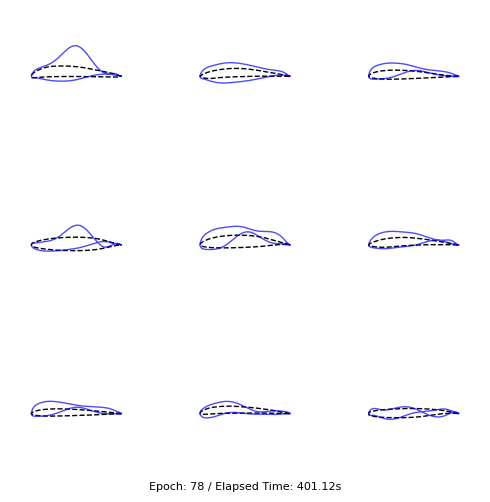

Epoch 79/3000: 100%|██████████| 32/32 [00:04<00:00,  6.73it/s]

Epoch 79/3000, Time: 406.02s, Total Loss: 0.0328, Reco Loss: 0.0311, KL Loss: 2.1625
Generating and plotting airfoils...


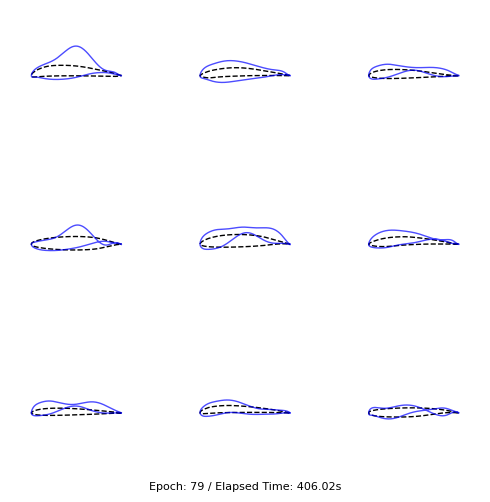

Epoch 80/3000: 100%|██████████| 32/32 [00:05<00:00,  6.10it/s]

Epoch 80/3000, Time: 411.35s, Total Loss: 0.0312, Reco Loss: 0.0295, KL Loss: 2.1294
Generating and plotting airfoils...


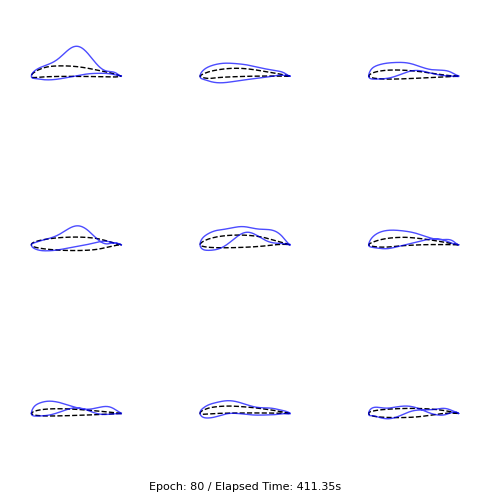

--- Saving model checkpoint for epoch 80 ---


Epoch 81/3000: 100%|██████████| 32/32 [00:05<00:00,  6.23it/s]

Epoch 81/3000, Time: 416.68s, Total Loss: 0.0315, Reco Loss: 0.0299, KL Loss: 2.1216
Generating and plotting airfoils...


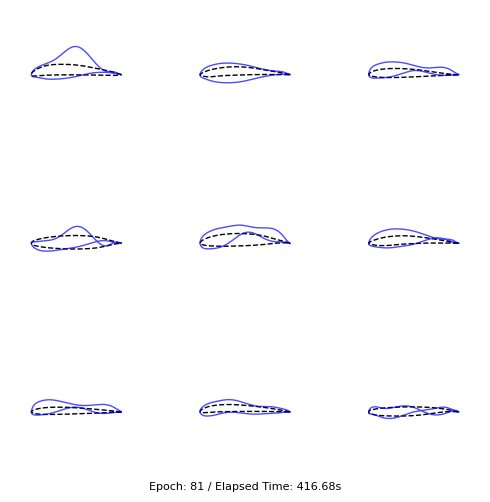

Epoch 82/3000: 100%|██████████| 32/32 [00:03<00:00,  8.08it/s]

Epoch 82/3000, Time: 420.73s, Total Loss: 0.0314, Reco Loss: 0.0296, KL Loss: 2.1324
Generating and plotting airfoils...


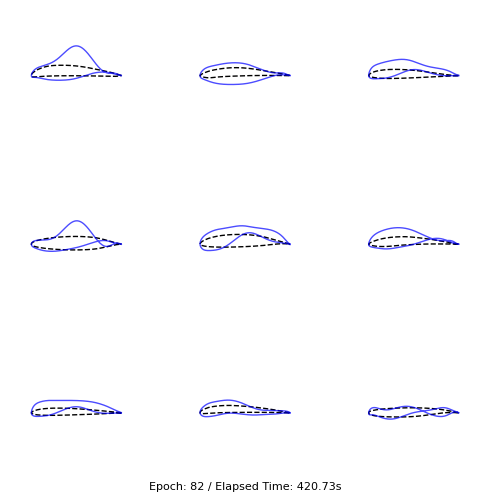

Epoch 83/3000: 100%|██████████| 32/32 [00:04<00:00,  6.95it/s]

Epoch 83/3000, Time: 425.43s, Total Loss: 0.0316, Reco Loss: 0.0298, KL Loss: 2.1346
Generating and plotting airfoils...


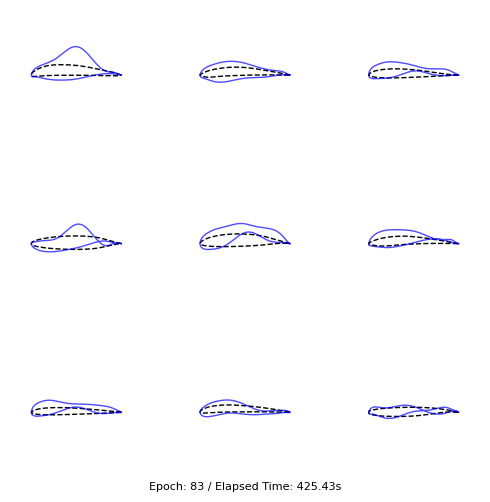

Epoch 84/3000: 100%|██████████| 32/32 [00:04<00:00,  6.78it/s]

Epoch 84/3000, Time: 430.23s, Total Loss: 0.0320, Reco Loss: 0.0302, KL Loss: 2.1524
Generating and plotting airfoils...


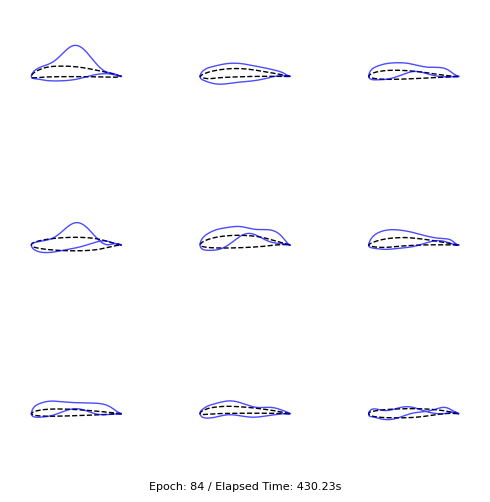

Epoch 85/3000: 100%|██████████| 32/32 [00:04<00:00,  7.25it/s]

Epoch 85/3000, Time: 434.77s, Total Loss: 0.0315, Reco Loss: 0.0297, KL Loss: 2.1473
Generating and plotting airfoils...


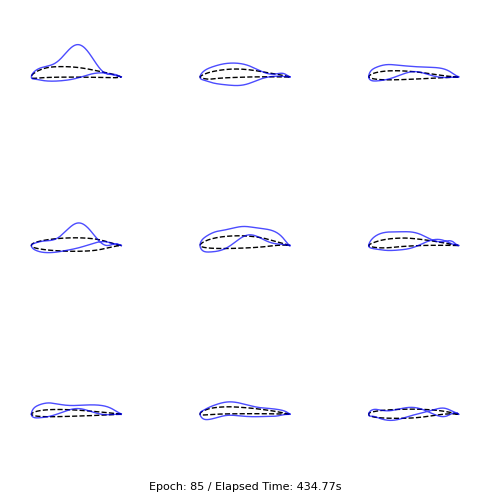

--- Saving model checkpoint for epoch 85 ---


Epoch 86/3000: 100%|██████████| 32/32 [00:04<00:00,  6.71it/s]

Epoch 86/3000, Time: 439.72s, Total Loss: 0.0310, Reco Loss: 0.0292, KL Loss: 2.1431
Generating and plotting airfoils...


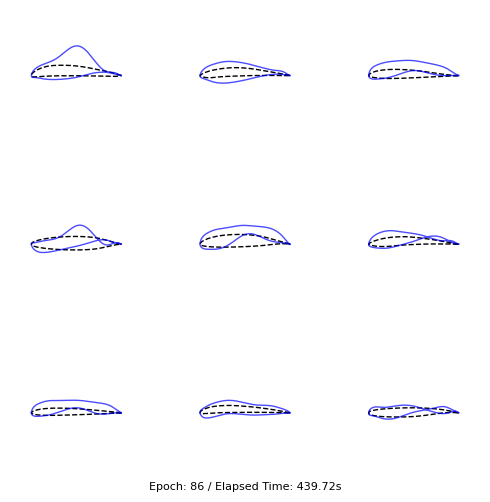

Epoch 87/3000: 100%|██████████| 32/32 [00:04<00:00,  7.30it/s]

Epoch 87/3000, Time: 444.20s, Total Loss: 0.0314, Reco Loss: 0.0295, KL Loss: 2.1494
Generating and plotting airfoils...


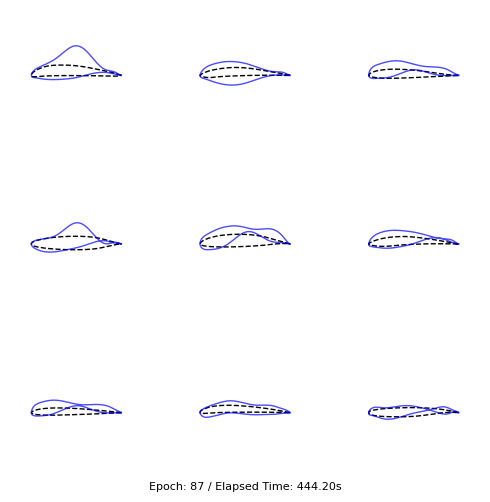

Epoch 88/3000: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]

Epoch 88/3000, Time: 470.56s, Total Loss: 0.0305, Reco Loss: 0.0287, KL Loss: 2.1391
Generating and plotting airfoils...


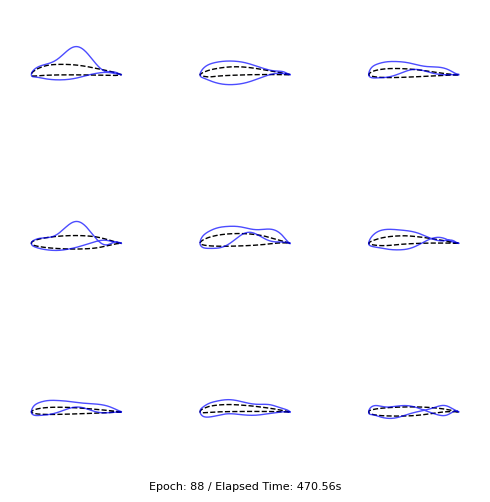

Epoch 89/3000: 100%|██████████| 32/32 [00:06<00:00,  5.28it/s]

Epoch 89/3000, Time: 476.72s, Total Loss: 0.0300, Reco Loss: 0.0281, KL Loss: 2.1494
Generating and plotting airfoils...


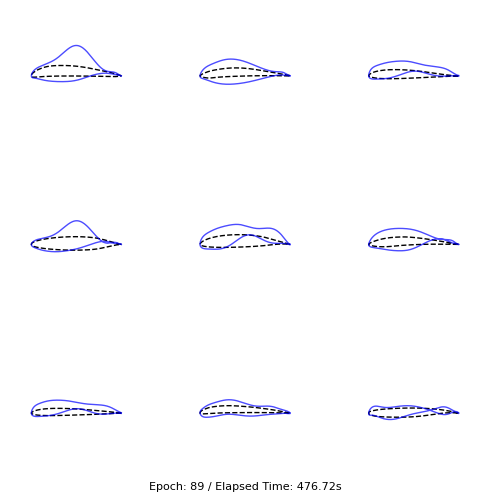

Epoch 90/3000: 100%|██████████| 32/32 [00:05<00:00,  6.08it/s]

Epoch 90/3000, Time: 482.08s, Total Loss: 0.0310, Reco Loss: 0.0291, KL Loss: 2.1616
Generating and plotting airfoils...


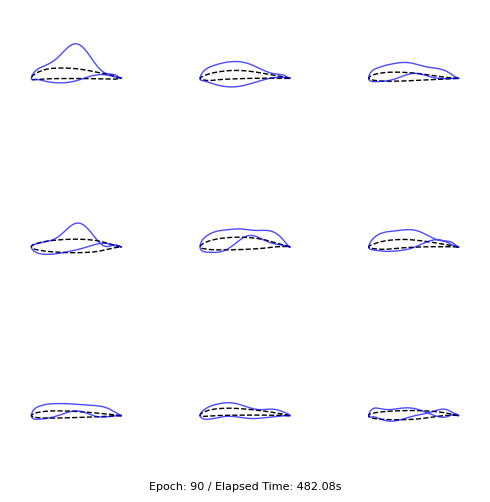

--- Saving model checkpoint for epoch 90 ---


Epoch 91/3000: 100%|██████████| 32/32 [00:04<00:00,  7.39it/s]

Epoch 91/3000, Time: 486.64s, Total Loss: 0.0300, Reco Loss: 0.0281, KL Loss: 2.1463
Generating and plotting airfoils...


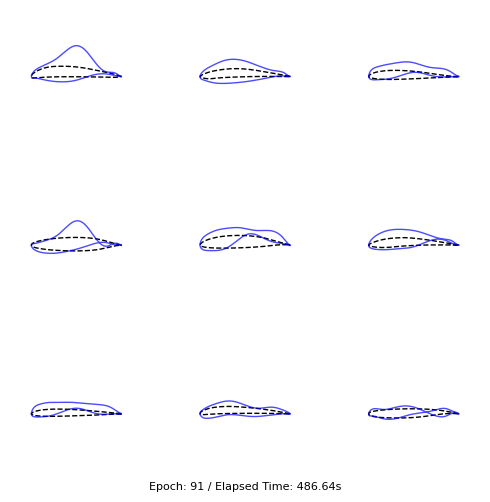

Epoch 92/3000: 100%|██████████| 32/32 [00:05<00:00,  5.60it/s]

Epoch 92/3000, Time: 492.46s, Total Loss: 0.0310, Reco Loss: 0.0291, KL Loss: 2.1539
Generating and plotting airfoils...


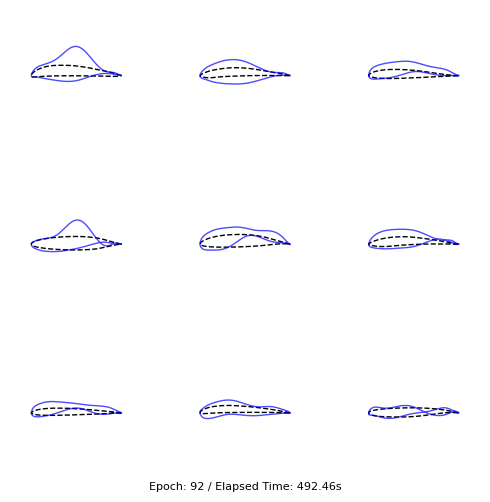

Epoch 93/3000: 100%|██████████| 32/32 [00:05<00:00,  5.72it/s]

Epoch 93/3000, Time: 498.17s, Total Loss: 0.0298, Reco Loss: 0.0278, KL Loss: 2.1590
Generating and plotting airfoils...


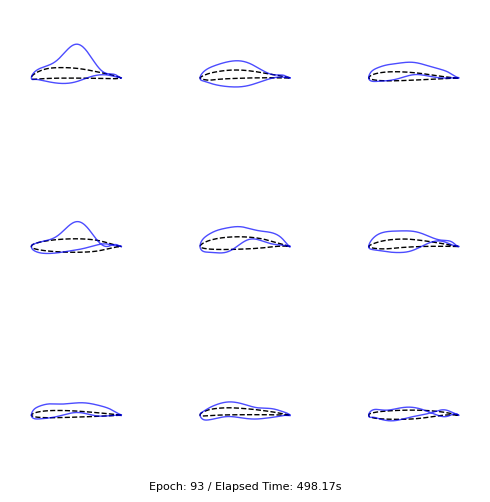

Epoch 94/3000: 100%|██████████| 32/32 [00:05<00:00,  6.02it/s]

Epoch 94/3000, Time: 503.57s, Total Loss: 0.0304, Reco Loss: 0.0284, KL Loss: 2.1498
Generating and plotting airfoils...


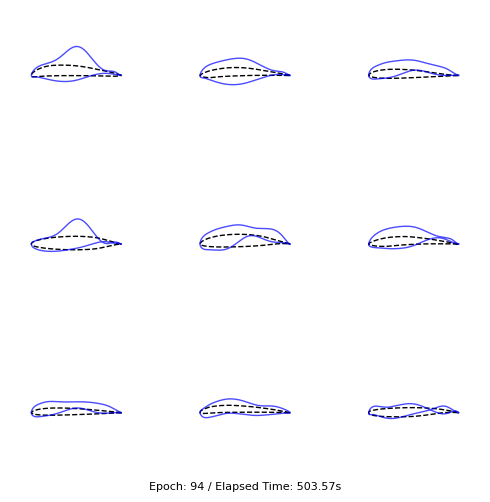

Epoch 95/3000: 100%|██████████| 32/32 [00:05<00:00,  6.34it/s]

Epoch 95/3000, Time: 508.70s, Total Loss: 0.0300, Reco Loss: 0.0280, KL Loss: 2.1497
Generating and plotting airfoils...


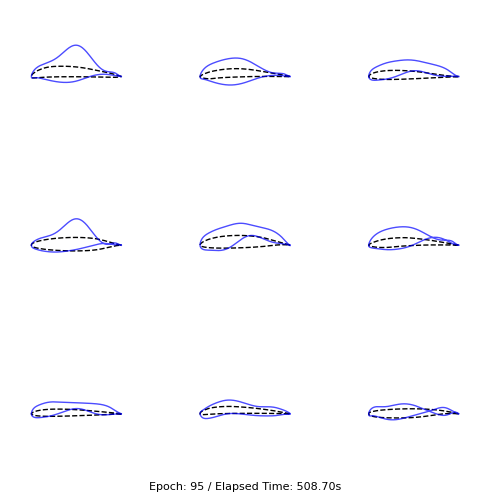

--- Saving model checkpoint for epoch 95 ---


Epoch 96/3000: 100%|██████████| 32/32 [00:05<00:00,  6.28it/s]

Epoch 96/3000, Time: 514.08s, Total Loss: 0.0304, Reco Loss: 0.0283, KL Loss: 2.1574
Generating and plotting airfoils...


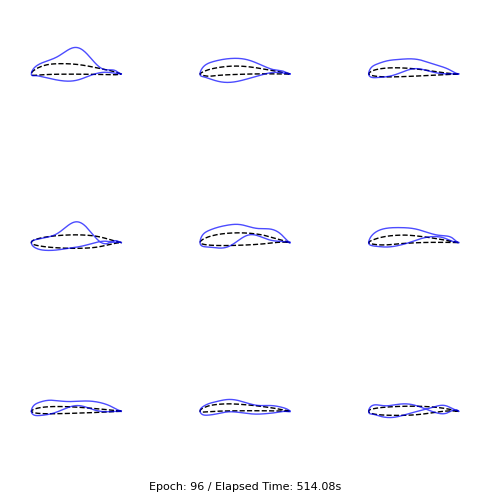

Epoch 97/3000: 100%|██████████| 32/32 [00:05<00:00,  5.86it/s]

Epoch 97/3000, Time: 519.63s, Total Loss: 0.0290, Reco Loss: 0.0270, KL Loss: 2.1491
Generating and plotting airfoils...


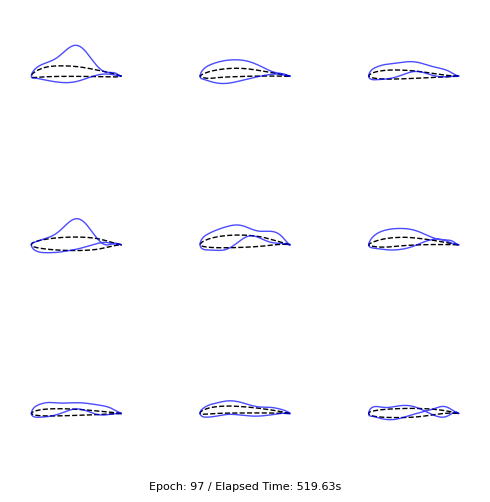

Epoch 98/3000: 100%|██████████| 32/32 [00:05<00:00,  5.76it/s]

Epoch 98/3000, Time: 525.28s, Total Loss: 0.0288, Reco Loss: 0.0267, KL Loss: 2.1558
Generating and plotting airfoils...


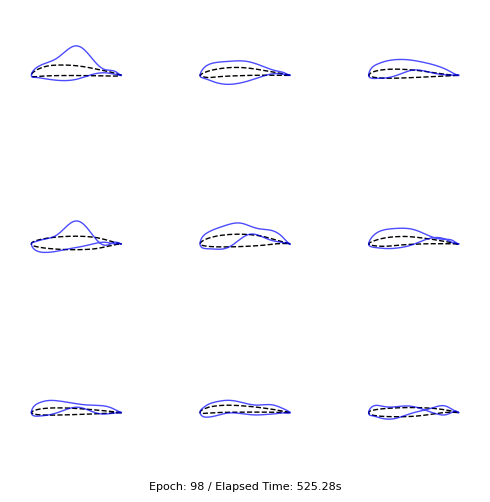

Epoch 99/3000: 100%|██████████| 32/32 [00:04<00:00,  6.69it/s]

Epoch 99/3000, Time: 530.17s, Total Loss: 0.0290, Reco Loss: 0.0268, KL Loss: 2.1608
Generating and plotting airfoils...


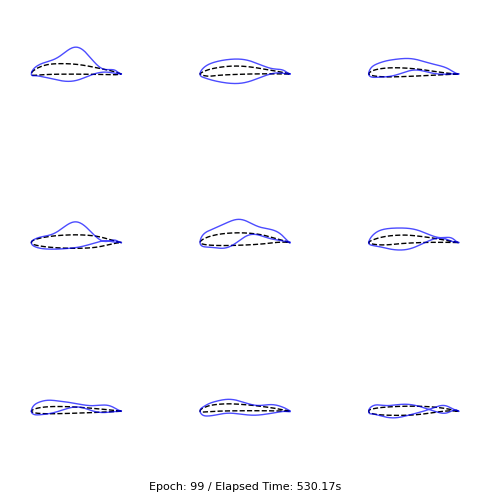

Epoch 100/3000: 100%|██████████| 32/32 [00:05<00:00,  6.34it/s]

Epoch 100/3000, Time: 535.33s, Total Loss: 0.0287, Reco Loss: 0.0266, KL Loss: 2.1525
Generating and plotting airfoils...


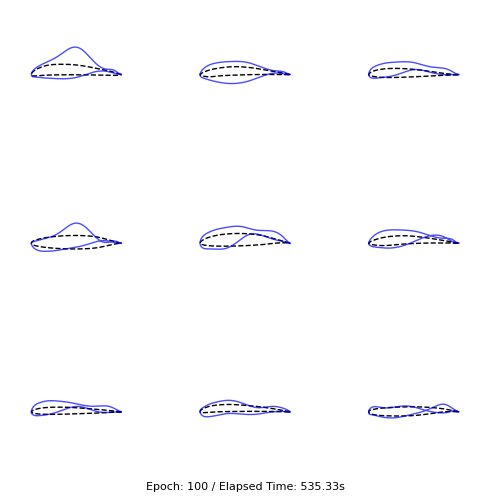

--- Saving model checkpoint for epoch 100 ---


Epoch 101/3000: 100%|██████████| 32/32 [00:05<00:00,  6.06it/s]

Epoch 101/3000, Time: 540.82s, Total Loss: 0.0290, Reco Loss: 0.0268, KL Loss: 2.1755
Generating and plotting airfoils...


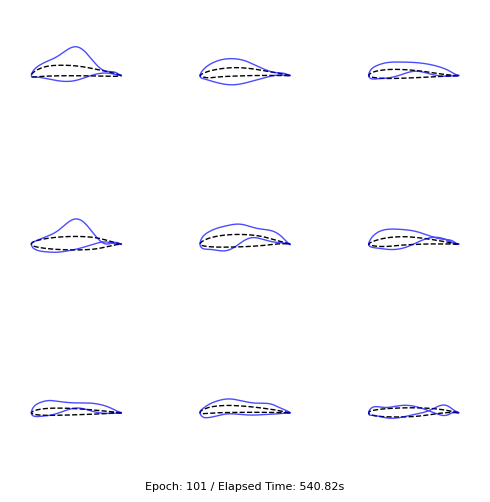

Epoch 102/3000: 100%|██████████| 32/32 [00:04<00:00,  6.40it/s]

Epoch 102/3000, Time: 545.90s, Total Loss: 0.0281, Reco Loss: 0.0259, KL Loss: 2.1651
Generating and plotting airfoils...


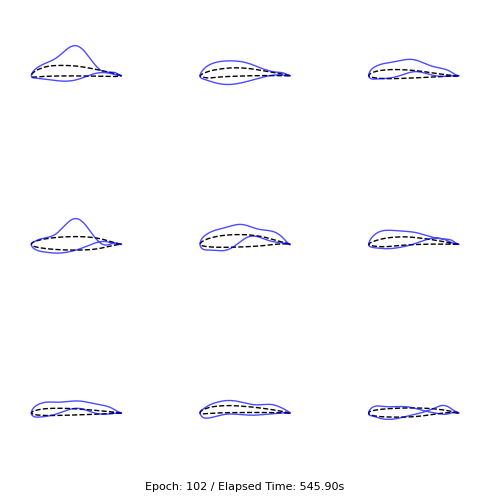

Epoch 103/3000: 100%|██████████| 32/32 [00:04<00:00,  7.01it/s]

Epoch 103/3000, Time: 550.58s, Total Loss: 0.0292, Reco Loss: 0.0270, KL Loss: 2.1675
Generating and plotting airfoils...


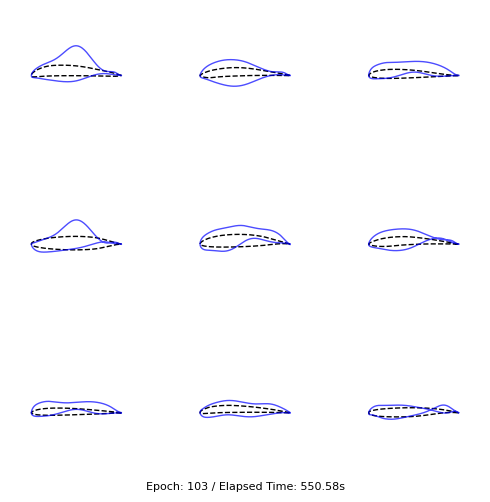

Epoch 104/3000: 100%|██████████| 32/32 [00:05<00:00,  6.32it/s]

Epoch 104/3000, Time: 555.73s, Total Loss: 0.0289, Reco Loss: 0.0266, KL Loss: 2.1702
Generating and plotting airfoils...


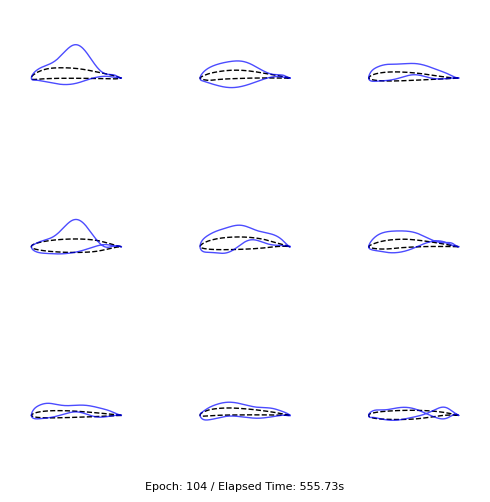

Epoch 105/3000: 100%|██████████| 32/32 [00:05<00:00,  6.18it/s]

Epoch 105/3000, Time: 561.00s, Total Loss: 0.0291, Reco Loss: 0.0268, KL Loss: 2.1845
Generating and plotting airfoils...


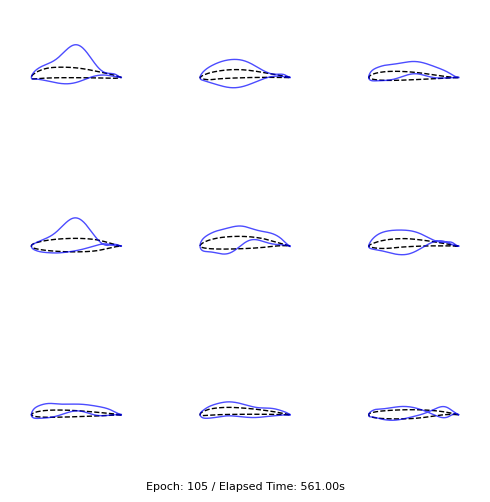

--- Saving model checkpoint for epoch 105 ---


Epoch 106/3000: 100%|██████████| 32/32 [00:05<00:00,  6.17it/s]

Epoch 106/3000, Time: 566.37s, Total Loss: 0.0287, Reco Loss: 0.0264, KL Loss: 2.1777
Generating and plotting airfoils...


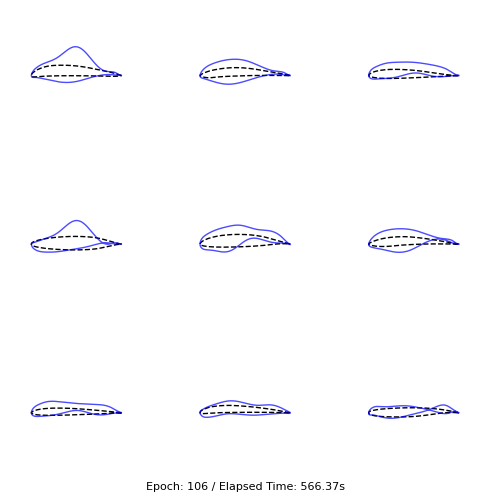

Epoch 107/3000: 100%|██████████| 32/32 [00:05<00:00,  5.92it/s]

Epoch 107/3000, Time: 571.91s, Total Loss: 0.0278, Reco Loss: 0.0255, KL Loss: 2.1936
Generating and plotting airfoils...


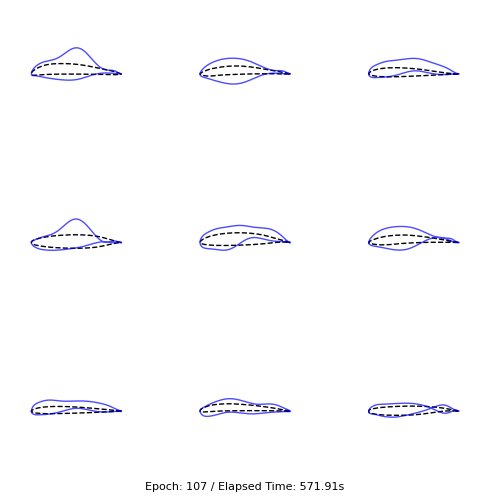

Epoch 108/3000: 100%|██████████| 32/32 [00:06<00:00,  5.26it/s]

Epoch 108/3000, Time: 578.08s, Total Loss: 0.0271, Reco Loss: 0.0247, KL Loss: 2.1941
Generating and plotting airfoils...


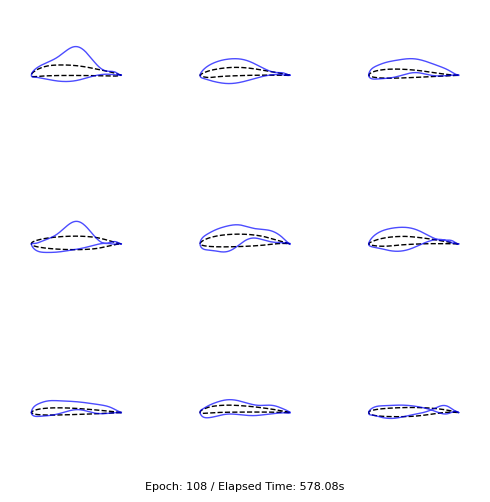

Epoch 109/3000: 100%|██████████| 32/32 [00:06<00:00,  5.05it/s]

Epoch 109/3000, Time: 584.53s, Total Loss: 0.0272, Reco Loss: 0.0249, KL Loss: 2.1944
Generating and plotting airfoils...


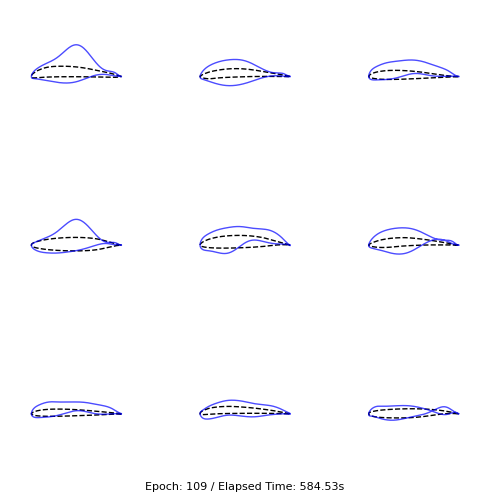

Epoch 110/3000: 100%|██████████| 32/32 [00:10<00:00,  3.18it/s]


Epoch 110/3000, Time: 594.74s, Total Loss: 0.0276, Reco Loss: 0.0252, KL Loss: 2.2061
Generating and plotting airfoils...


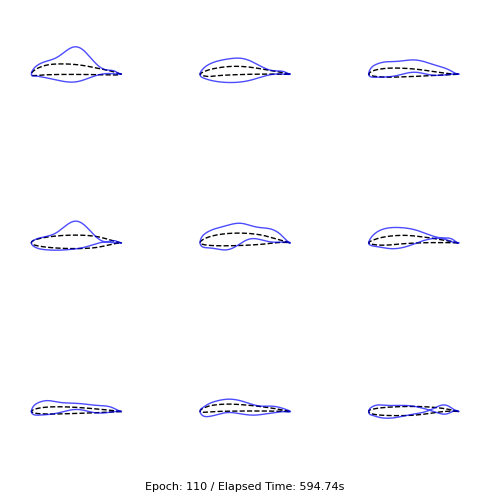

--- Saving model checkpoint for epoch 110 ---


Epoch 111/3000: 100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


Epoch 111/3000, Time: 606.47s, Total Loss: 0.0275, Reco Loss: 0.0251, KL Loss: 2.1909
Generating and plotting airfoils...


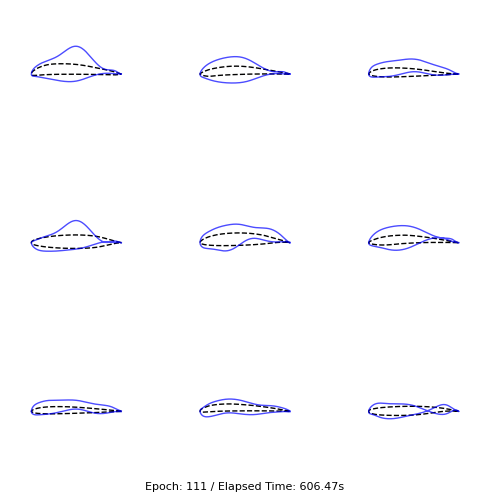

Epoch 112/3000: 100%|██████████| 32/32 [00:11<00:00,  2.77it/s]


Epoch 112/3000, Time: 618.29s, Total Loss: 0.0276, Reco Loss: 0.0251, KL Loss: 2.1909
Generating and plotting airfoils...


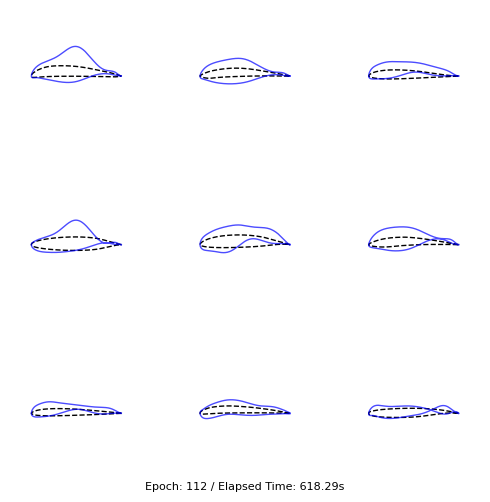

Epoch 113/3000: 100%|██████████| 32/32 [00:11<00:00,  2.69it/s]

Epoch 113/3000, Time: 630.43s, Total Loss: 0.0280, Reco Loss: 0.0255, KL Loss: 2.1841
Generating and plotting airfoils...


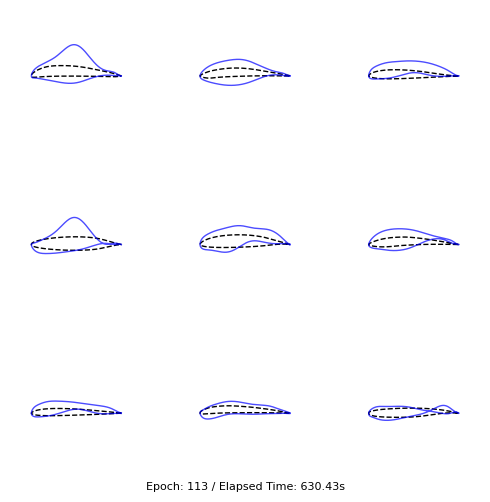

Epoch 114/3000: 100%|██████████| 32/32 [00:11<00:00,  2.73it/s]


Epoch 114/3000, Time: 642.36s, Total Loss: 0.0272, Reco Loss: 0.0247, KL Loss: 2.1904
Generating and plotting airfoils...


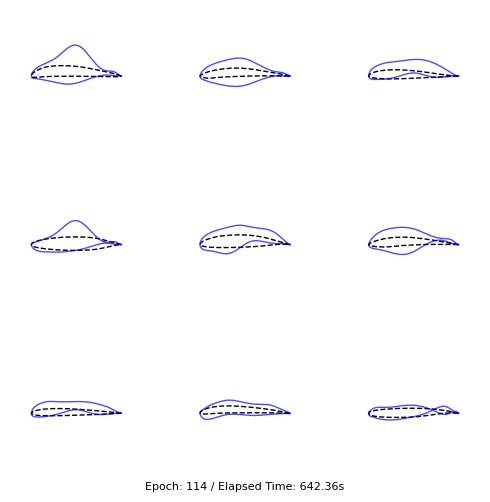

Epoch 115/3000: 100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


Epoch 115/3000, Time: 653.95s, Total Loss: 0.0268, Reco Loss: 0.0243, KL Loss: 2.1914
Generating and plotting airfoils...


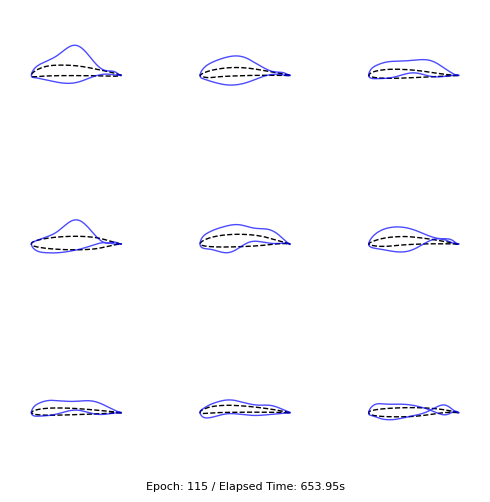

--- Saving model checkpoint for epoch 115 ---


Epoch 116/3000: 100%|██████████| 32/32 [00:11<00:00,  2.75it/s]


Epoch 116/3000, Time: 666.05s, Total Loss: 0.0269, Reco Loss: 0.0243, KL Loss: 2.2061
Generating and plotting airfoils...


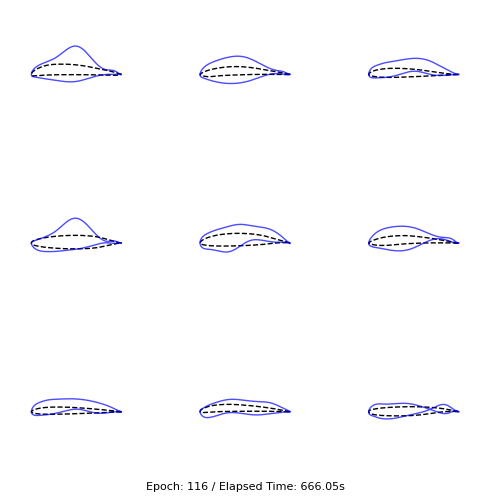

Epoch 117/3000: 100%|██████████| 32/32 [00:11<00:00,  2.86it/s]


Epoch 117/3000, Time: 677.52s, Total Loss: 0.0277, Reco Loss: 0.0251, KL Loss: 2.2000
Generating and plotting airfoils...


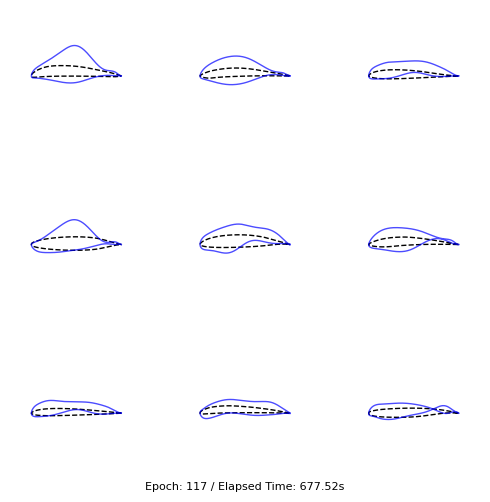

Epoch 118/3000: 100%|██████████| 32/32 [00:11<00:00,  2.88it/s]

Epoch 118/3000, Time: 688.87s, Total Loss: 0.0266, Reco Loss: 0.0241, KL Loss: 2.2030
Generating and plotting airfoils...


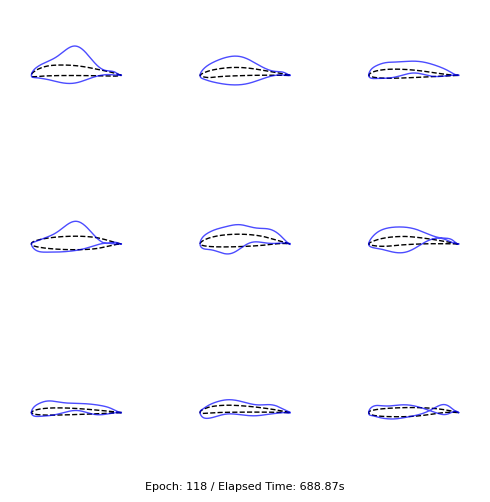

Epoch 119/3000: 100%|██████████| 32/32 [00:11<00:00,  2.71it/s]

Epoch 119/3000, Time: 700.91s, Total Loss: 0.0261, Reco Loss: 0.0235, KL Loss: 2.1924
Generating and plotting airfoils...


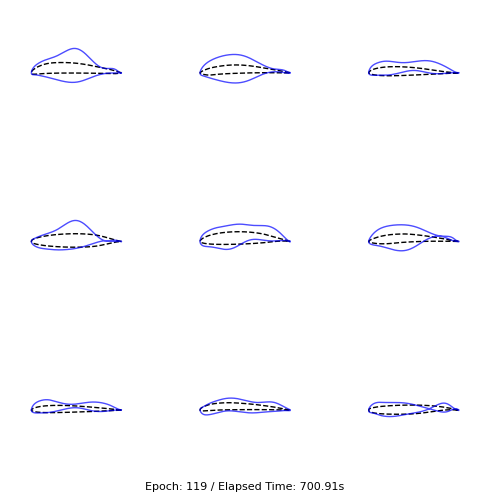

Epoch 120/3000: 100%|██████████| 32/32 [00:11<00:00,  2.72it/s]


Epoch 120/3000, Time: 712.88s, Total Loss: 0.0272, Reco Loss: 0.0246, KL Loss: 2.2010
Generating and plotting airfoils...


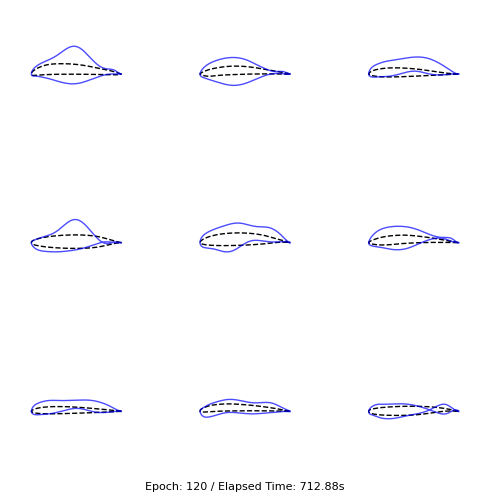

--- Saving model checkpoint for epoch 120 ---


Epoch 121/3000: 100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


Epoch 121/3000, Time: 724.66s, Total Loss: 0.0268, Reco Loss: 0.0242, KL Loss: 2.1878
Generating and plotting airfoils...


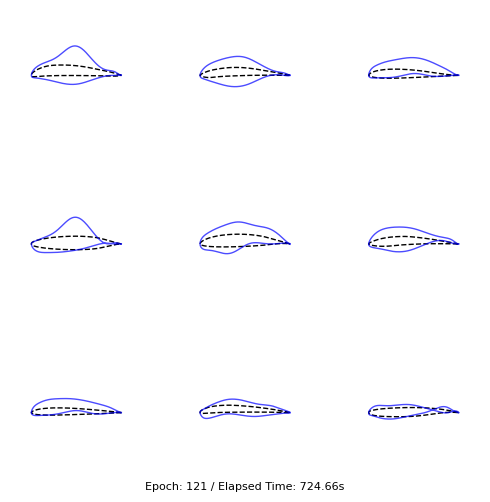

Epoch 122/3000: 100%|██████████| 32/32 [00:11<00:00,  2.88it/s]


Epoch 122/3000, Time: 736.04s, Total Loss: 0.0267, Reco Loss: 0.0241, KL Loss: 2.1909
Generating and plotting airfoils...


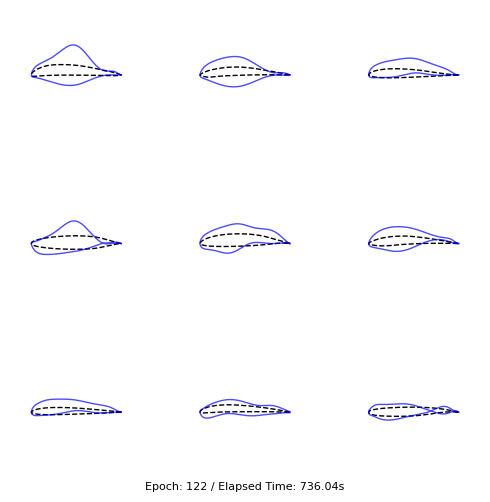

Epoch 123/3000: 100%|██████████| 32/32 [00:10<00:00,  2.98it/s]


Epoch 123/3000, Time: 747.01s, Total Loss: 0.0259, Reco Loss: 0.0232, KL Loss: 2.1960
Generating and plotting airfoils...


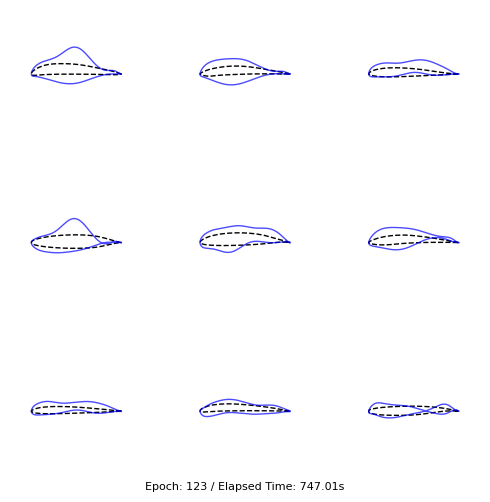

Epoch 124/3000: 100%|██████████| 32/32 [00:10<00:00,  3.03it/s]

Epoch 124/3000, Time: 757.82s, Total Loss: 0.0261, Reco Loss: 0.0234, KL Loss: 2.1996
Generating and plotting airfoils...


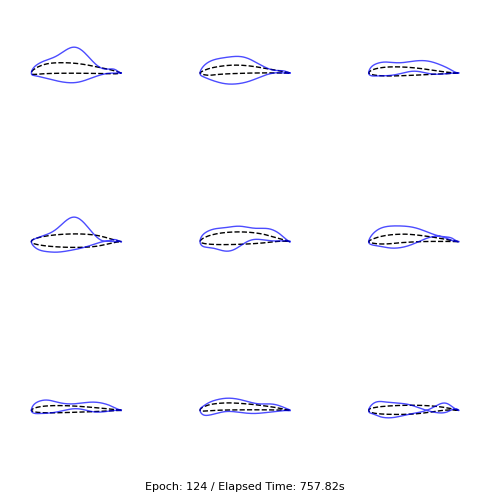

Epoch 125/3000: 100%|██████████| 32/32 [00:10<00:00,  2.99it/s]


Epoch 125/3000, Time: 768.72s, Total Loss: 0.0268, Reco Loss: 0.0241, KL Loss: 2.2047
Generating and plotting airfoils...


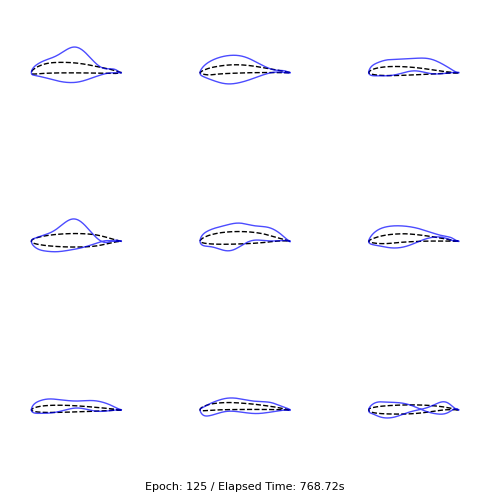

--- Saving model checkpoint for epoch 125 ---


Epoch 126/3000: 100%|██████████| 32/32 [00:10<00:00,  3.05it/s]

Epoch 126/3000, Time: 779.64s, Total Loss: 0.0271, Reco Loss: 0.0244, KL Loss: 2.1913
Generating and plotting airfoils...


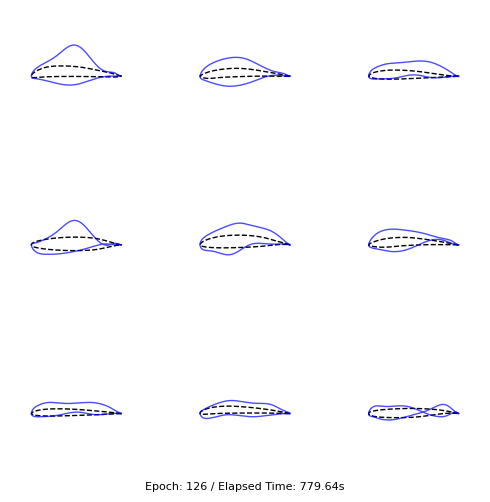

Epoch 127/3000: 100%|██████████| 32/32 [00:10<00:00,  3.00it/s]

Epoch 127/3000, Time: 790.53s, Total Loss: 0.0262, Reco Loss: 0.0234, KL Loss: 2.1942
Generating and plotting airfoils...


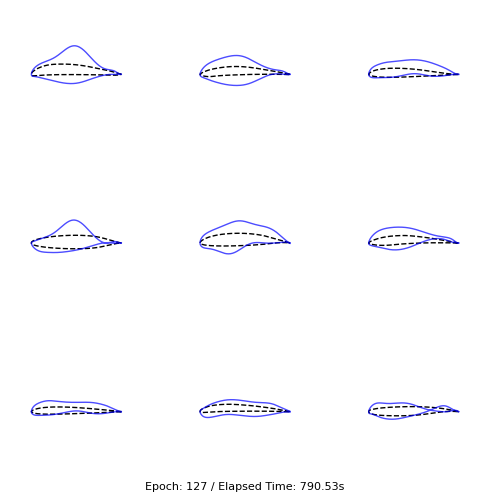

Epoch 128/3000: 100%|██████████| 32/32 [00:11<00:00,  2.88it/s]


Epoch 128/3000, Time: 801.85s, Total Loss: 0.0260, Reco Loss: 0.0232, KL Loss: 2.1877
Generating and plotting airfoils...


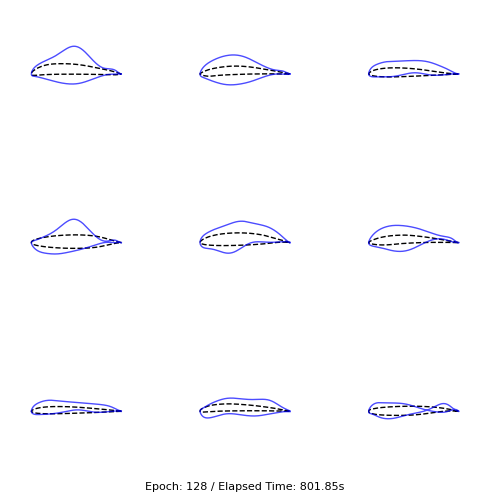

Epoch 129/3000: 100%|██████████| 32/32 [00:10<00:00,  3.05it/s]


Epoch 129/3000, Time: 812.57s, Total Loss: 0.0261, Reco Loss: 0.0233, KL Loss: 2.1977
Generating and plotting airfoils...


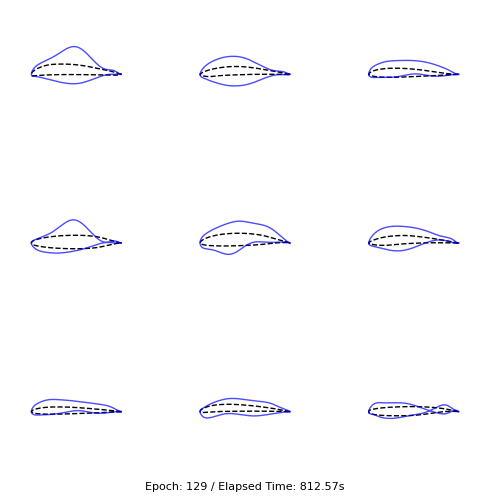

Epoch 130/3000: 100%|██████████| 32/32 [00:10<00:00,  2.93it/s]


Epoch 130/3000, Time: 823.70s, Total Loss: 0.0253, Reco Loss: 0.0225, KL Loss: 2.1954
Generating and plotting airfoils...


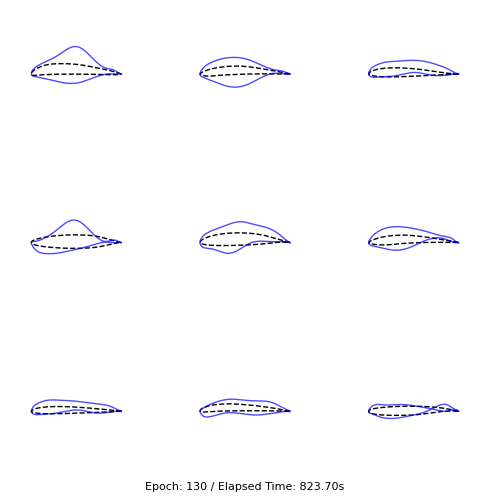

--- Saving model checkpoint for epoch 130 ---


Epoch 131/3000: 100%|██████████| 32/32 [00:13<00:00,  2.42it/s]

Epoch 131/3000, Time: 837.64s, Total Loss: 0.0257, Reco Loss: 0.0229, KL Loss: 2.1941
Generating and plotting airfoils...


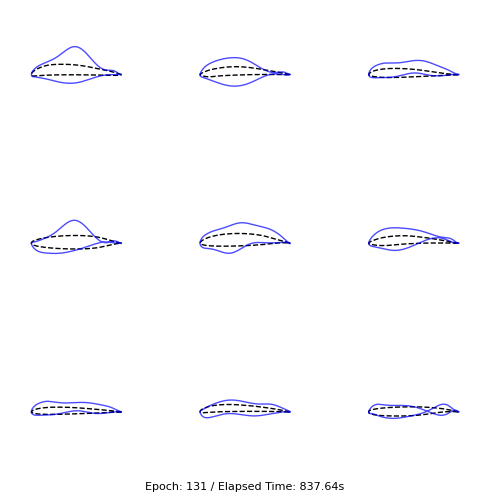

Epoch 132/3000: 100%|██████████| 32/32 [00:06<00:00,  4.73it/s]

Epoch 132/3000, Time: 844.51s, Total Loss: 0.0256, Reco Loss: 0.0227, KL Loss: 2.1898
Generating and plotting airfoils...


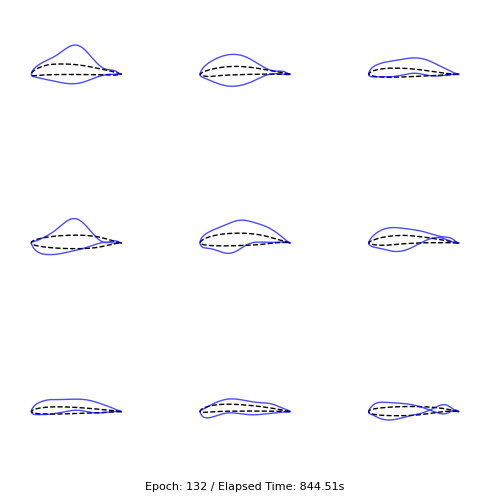

Epoch 133/3000:  97%|█████████▋| 31/32 [00:03<00:00, 23.36it/s]

In [ ]:
wandb.init(
    project="CSTVAE",  
    config=HYPERPARAMETERS,
    name=f"VAE_{time.strftime('%Y%m%d-%H%M%S')}",
    notes="TANH no decoder + Scaler + MAE"
)

VERBOSE = 1

# Ensure the models directory exists
models_path = Path(proj_path) / "models" / "cstvae" / time.strftime("%Y%m%d-%H%M%S")
images_path = Path(proj_path) / "images" / "cstvae" / time.strftime("%Y%m%d-%H%M%S")
os.makedirs(models_path, exist_ok=True)
os.makedirs(images_path, exist_ok=True)

# --- The Main Training Loop ---
print("Starting training...")
start_time = time.time()

for epoch in range(EPOCHS):
    
    # Reset metrics at the start of each epoch
    epoch_total_loss = tf.keras.metrics.Mean()
    epoch_reco_loss = tf.keras.metrics.Mean()
    epoch_kl_loss = tf.keras.metrics.Mean()

    # Linear ramp for BETA
    if epoch < WARMUP_EPOCHS:
        BETA = TARGET_BETA * (epoch / WARMUP_EPOCHS)
    else:
        BETA = TARGET_BETA
    
    wandb.log({'beta': BETA})

    # Iterate over each batch in the dataset
    for x_batch in tqdm(train_dataset, desc=f"Epoch {epoch+1}/{EPOCHS}"):

        # Run one training step
        total_loss, reco_loss, kl_loss = train_step(x_batch, BETA)
        
        # Update the epoch's average loss
        epoch_total_loss.update_state(total_loss)
        epoch_reco_loss.update_state(reco_loss)
        epoch_kl_loss.update_state(kl_loss)

    # --- End of Epoch ---
    elapsed_time = time.time() - start_time
    
    if VERBOSE > 0:
        # Print metrics
        print(f"Epoch {epoch+1}/{EPOCHS}, "
            f"Time: {elapsed_time:.2f}s, "
            f"Total Loss: {epoch_total_loss.result():.4f}, "
            f"Reco Loss: {epoch_reco_loss.result():.4f}, "
            f"KL Loss: {epoch_kl_loss.result():.4f}")
    
    wandb.log({
        'epoch_total_loss': epoch_total_loss.result(),
        'epoch_reconstruction_loss': epoch_reco_loss.result(),
        'epoch_kl_loss': epoch_kl_loss.result()
    })

    print("Generating and plotting airfoils...")
    
    # Reconstructing initial validation airfoils
    # reco_coords, _, _ = vae(validation_input, training=False)
    # reco_airfoils = [Airfoil(coordinates=coords).to_kulfan_airfoil(NPV) for coords in np.array(reco_coords)]
    _, reco_weights, reco_params = vae(validation_input, training=False)

    # Assuming you have already run:
    real_reco_weights, real_reco_params = vae.scaler.inverse_transform(reco_weights.numpy(), reco_params.numpy())

    reconstructed_airfoils = []

    for i in range(len(real_reco_weights)):
        # 1. Extract Weights for this sample
        # Shape of real_reco_weights is likely (Batch, 2, NPV)
        # Row 0 = Lower Surface, Row 1 = Upper Surface
        lower_w = real_reco_weights[i][0] 
        upper_w = real_reco_weights[i][1]
        
        # 2. Extract Parameters for this sample
        # Based on your data loading order: [TE_thickness, leading_edge_weight]
        te_thickness = real_reco_params[i][0]
        le_weight = real_reco_params[i][1]
        
        # 3. Instantiate KulfanAirfoil
        # Note: Ensure arguments match the library's definition
        kulfan_af = KulfanAirfoil(
            name=f"Reconstructed_{i}",
            lower_weights=lower_w,
            upper_weights=upper_w,
            leading_edge_weight=le_weight,
            TE_thickness=te_thickness
        )
        
        reconstructed_airfoils.append(kulfan_af)

    real_reco_weights, real_reco_params = vae.scaler.inverse_transform(reco_weights.numpy(), reco_params.numpy())

    # reco_airfoils = [Airfoil(coordinates=coords).to_kulfan_airfoil(NPV) for coords in np.array(reco_coords)]
    
    plot_original_and_reconstruction(validation_airfoils, reconstructed_airfoils, text_label=f"Epoch: {epoch+1} / Elapsed Time: {elapsed_time:.2f}s", save_path=images_path, filename=f"reconstruction_epoch_{epoch+1}.png")

    # generate_and_plot_airfoils(
    #     vae.decoder, # Note: we pass vae.decoder, not a 'generator'
    #     epoch=epoch, 
    #     time=elapsed_time,
    #     save_path=images_path,
    #     show=True,
    #     dpi=200
    # )

    # Save model checkpoints every 5 epochs
    if (epoch + 1) % 5 == 0:
        print(f"--- Saving model checkpoint for epoch {epoch+1} ---")
        vae.save(f"{models_path}/model_epoch_{epoch+1}.keras")

print("Training complete.")

In [ ]:
import glob
from PIL import Image
from IPython.display import Image as IPImage # Use an alias to avoid name conflict

# image_path_path = Path(proj_path) / "images" / "cstvae" / "20251122-004235"

# --- Step 1: Find your image files ---
image_folder_path = str(images_path) + "/*.png"

# Get a *sorted* list of file paths.
# Sorting is CRITICAL to make sure your frames are in the right order.
file_paths = sorted(glob.glob(image_folder_path + "/*.png"))

# --- Step 2: Load the images ---
# Open the first image, and then all the subsequent images
images = [Image.open(fp) for fp in file_paths]
first_image = images[0]
other_images = images[1:]

# --- Step 3: Save the images as a GIF ---
gif_path = str(images_path) + "/animated.gif"

first_image.save(
    gif_path,
    format="GIF",
    append_images=other_images,  # The list of images to append
    save_all=True,
    duration=100,                # Milliseconds per frame (e.g., 100ms = 10 fps)
    loop=0                       # 0 = loop forever
)

# --- Step 4: Display the GIF in Jupyter ---
# This will embed the GIF directly into your notebook output
IPImage(filename=gif_path)

NameError: name 'Path' is not defined